In [1]:
import csv
import os

import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error

2024-11-17 00:54:25.564241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-17 00:54:25.699953: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 00:54:26.206574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/include/opencv4
2024-11-17 00:54:26.206645: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvi

In [2]:
class PredictionCallback(Callback):
    def __init__(self, val_data):
        super(PredictionCallback, self).__init__()
        self.val_data = val_data

    def on_train_end(self, logs=None):

        # model testing
        val_pred_all = []
        val_true_all = []

        # Loop through the entire validation dataset
        for batch in self.val_data:
            inputs, y_true = batch
            y_pred = self.model.predict(inputs)
            for i in range(y_true.shape[0]):
                distance, _ = self.find_largest_diag(y_pred[i])
                val_pred_all.append(distance)
                distance, _ = self.find_largest_diag(y_true[i])
                val_true_all.append(distance)

        # Display final predictions for the first 30 samples
        print("\nFinal predictions after training:")
        print("Predicted:", val_pred_all[:30])
        print("True:", val_true_all[:30])

        # f1 score, accuracy, mae
        f1 = f1_score(val_true_all, val_pred_all, average='weighted')
        acc = accuracy_score(val_true_all, val_pred_all)
        mae = mean_absolute_error(val_true_all, val_pred_all)

        print(f"accuracy in total: {acc}")
        print(f"f1 score: {f1}")
        print(f"mean absolute error: {mae}")
        
    def find_largest_diag(self, similarity_matrix):
        # Get matrix dimensions
        n = similarity_matrix.shape[0]

        # Convert to TensorFlow tensor
        sim_matrix = tf.constant(similarity_matrix, dtype=tf.float32)

        # Find the position of the maximum value in each row
        row_max_indices = []
        for i in range(n):
            row_idx = tf.argmax(sim_matrix[i, :])
            row_max_indices.append(tf.round(row_idx))  # Round the softargmax result to integer index
        row_max_indices = tf.stack(row_max_indices)
        # print("Row max indices (rounded):", row_max_indices)

        # Find the position of the maximum value in each column
        col_max_indices = []
        for i in range(n):
            col_idx = tf.argmax(sim_matrix[:, i])
            col_max_indices.append(tf.round(col_idx))  # Similarly, round each column result
        col_max_indices = tf.stack(col_max_indices)
        # print("Column max indices (rounded):", col_max_indices)

        # Create a heatmap to mark the maximum values
        heatmap = np.zeros_like(similarity_matrix)
        for i in range(n):
            row_idx = int(row_max_indices[i].numpy())
            col_idx = int(col_max_indices[i].numpy())

            # Ensure indices are within matrix dimensions
            if 0 <= row_idx < n:
                heatmap[i, row_idx] += 1  # Mark the maximum value in each row
            if 0 <= col_idx < n:
                heatmap[col_idx, i] += 1  # Mark the maximum value in each column

        # Find the diagonal with the most marks
        max_diag_marks = -1
        max_diag_idx = 0
        for diag_idx in range(-n + 1, n):
            diag_marks = np.sum(np.diag(heatmap, k=diag_idx))
            if diag_marks > max_diag_marks:
                max_diag_marks = diag_marks
                max_diag_idx = diag_idx

        # Calculate the distance of the optimal diagonal from the center diagonal
        distance = max_diag_idx

        # Return the distance and the heatmap
        return distance, heatmap

In [3]:
def get_positional_encoding(seq_len, embed_dim):
    """
    Generates the positional encoding matrix for the input sequence.
    Args:
        seq_len (int): The length of the input sequence.
        embed_dim (int): The embedding dimension.
    Returns:
        tf.Tensor: A tensor containing positional encodings.
    """
    position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # Shape (seq_len, 1)
    div_term = tf.exp(tf.range(0, embed_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embed_dim))  # Shape (embed_dim//2,)

    # Apply sin to even indices and cos to odd indices
    sine = tf.sin(position * div_term)
    cosine = tf.cos(position * div_term)
    pos_enc = tf.concat([sine, cosine], axis=-1)

    # Handle case where embed_dim is odd
    if embed_dim % 2 != 0:
        pos_enc = tf.concat([pos_enc, tf.zeros((seq_len, 1))], axis=-1)

    return pos_enc

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, nhead):
        super(EncoderLayer, self).__init__()

        self.nhead = nhead
        self.attention = layers.MultiHeadAttention(num_heads=self.nhead, key_dim=d_model,dropout=0.1)
        self.merge = layers.Dense(d_model, use_bias=False)

        # feed-forward network
        self.mlp = tf.keras.Sequential([
            layers.Dense(d_model * 2, activation='relu'),
            layers.Dropout(0.1)
            layers.Dense(d_model),
        ])

        # norm layers
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)

        # Dropout Layers
        self.dropout1 = tf.keras.layers.Dropout(0.1)
        self.dropout2 = tf.keras.layers.Dropout(0.1)

    def call(self, x, source):
        # Multi-Head Attention with Skip Connection
        attn_output = self.attention(query=x, key=source, value=source)
        out1 = self.norm1(x + attn_output)

        # Feed-Forward Network with Skip Connection
        ffn_output = self.mlp(out1)  # x --> query
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)

        return out2

In [4]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads=4, embed_dim=48, num_layers=2, sequence_length=20):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.sequence_length = sequence_length

        self.mask_token = self.add_weight("dustbin_token", shape=[1, 1, embed_dim], initializer="zeros", trainable=False)
        # self.mask_token = self.add_weight("class_token", shape=[1, 1, embed_dim], initializer="zeros", trainable=True)

        # Transformer Encoder layers (Now using cross-attention)
        self.encoder_layers = [
            EncoderLayer(d_model=embed_dim, nhead=num_heads)
            for _ in range(num_layers * 2)
        ]

        self.multiHeadattention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=self.embed_dim)

    def call(self, inputs, training=True):
        query = inputs['query']
        context = inputs['context']
        batch_size = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]

        mask_token = tf.broadcast_to(self.mask_token, [batch_size, 1, self.embed_dim])

        query = tf.concat([query, mask_token], axis=1)
        context = tf.concat([context, mask_token], axis=1)

        seq_len = seq_len + 1

        # Incorporate positional encoding
        self.positional_encoding = get_positional_encoding(seq_len, self.embed_dim)

        # Add positional encoding to query and context after concatenating the class token
        query += self.positional_encoding[:seq_len, :]  # Adding positional encoding for sequence
        context += self.positional_encoding[:seq_len, :]

        # Pass through transformer encoder layers using cross-attention
        for i, encoder_layer in enumerate(self.encoder_layers):
            if i % 2 == 0:
                # self-attention
                query = encoder_layer(query, query)
                context = encoder_layer(context, context)

            else:
                # cross-attention
                query = encoder_layer(query, context)
                context = encoder_layer(context, query)

        _, attention_scores = self.multiHeadattention(query=query, key=context, value=context,
                                                      return_attention_scores=True)

        similarity_matrix = tf.reduce_mean(attention_scores, axis=1)

        return similarity_matrix

    def create_diag_matrix(self, y):
        # Create a matrix of shape (sequence_length + 1, sequence_length + 1)
        matrix = np.zeros((self.sequence_length + 1, self.sequence_length + 1), dtype=np.float32)

        diag_offset = int(y)
        if -self.sequence_length < diag_offset < self.sequence_length:
            effective_length = max(0, self.sequence_length - abs(diag_offset))
            if effective_length > 0:
                np.fill_diagonal(matrix[max(0, -diag_offset):self.sequence_length,
                                 max(0, diag_offset):self.sequence_length], 1)

        # Add the last row and last column as the "dustbin"
        for i in range(self.sequence_length):
            # If the row contains a 1, mark the last column as 0; otherwise, mark as 1
            matrix[i, -1] = 0 if np.any(matrix[i, :self.sequence_length] == 1) else 1
        for j in range(self.sequence_length):
            # If the column contains a 1, mark the last row as 0; otherwise, mark as 1
            matrix[-1, j] = 0 if np.any(matrix[:self.sequence_length, j] == 1) else 1

        return matrix

    def map_fn(self, features, y_label):
        # Use py_function to call create_diag_matrix and convert it to a TensorFlow tensor
        diag_matrix = tf.py_function(func=self.create_diag_matrix, inp=[y_label], Tout=tf.float32)
        # Ensure the diag_matrix shape is set to (sequence_length + 1, sequence_length + 1)
        diag_matrix.set_shape((self.sequence_length + 1, self.sequence_length + 1))
        return features, diag_matrix

    def train(self, pathSimilarityVectorsArray: str, pathSimilarityVectorsArray_val:str, batch_size=256, epochs=100, learning_rate=1e-3, weight_name=""):
        """
        Args:
            train_dataset (tf.data.Dataset): Training dataset.
            val_dataset (tf.data.Dataset): Validation dataset.
            epochs (int): Number of epochs to train for.
            learning_rate (float): Learning rate for the optimizer.
            train_steps_per_epoch (int): Number of training steps per epoch.
            val_steps_per_epoch (int): Number of validation steps per epoch.
        """

        trainDS = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)
        valDS = np.load(fr"{pathSimilarityVectorsArray_val}", allow_pickle=True)

        # Extracting the features and labels from the training dataset
        left_features_train = trainDS[:, 0].tolist()
        right_features_train = trainDS[:, 1].tolist()
        y_train = trainDS[:, 4].tolist()

        # Convert lists to numpy arrays and then to tensors
        left_features_train = np.array(left_features_train)
        right_features_train = np.array(right_features_train)
        y_train = np.array(y_train).astype(np.float32)

        left_features_train = tf.convert_to_tensor(left_features_train, dtype=tf.float32)
        right_features_train = tf.convert_to_tensor(right_features_train, dtype=tf.float32)


        # Extracting the features and labels from the training dataset
        left_features_val = valDS[:, 0].tolist()
        right_features_val = valDS[:, 1].tolist()
        y_val = valDS[:, 4].tolist()

        # Convert lists to numpy arrays and then to tensors
        left_features_val = np.array(left_features_val)
        right_features_val = np.array(right_features_val)
        y_val = np.array(y_val).astype(np.float32)

        left_features_val= tf.convert_to_tensor(left_features_val, dtype=tf.float32)
        right_features_val = tf.convert_to_tensor(right_features_val, dtype=tf.float32)

        # # Split the dataset into training and validation sets
        # size = int(len(y) * 0.8)  # Use 80% of the data for training
        # left_features_train, left_features_val = left_features[:size], left_features[size:]
        # right_features_train, right_features_val = right_features[:size], right_features[size:]
        # y_train, y_val = y[:size], y[size:]

        # Creating TensorFlow datasets without preprocessing labels in advanceW
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features_train, 'context': right_features_train}, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=2048)

        # Use a map function to convert y to diagonal matrices
        train_dataset = train_dataset.map(self.map_fn).batch(batch_size, drop_remainder=True).repeat()

        # Construct the validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features_val, 'context': right_features_val}, y_val))
        val_dataset = val_dataset.map(self.map_fn).batch(512, drop_remainder=True)

        # Calculate the number of training and validation steps per epoch
        train_steps_per_epoch = max(1, len(left_features_train) // batch_size)
        val_steps_per_epoch = max(1, len(left_features_val) // 512)

        # Add ModelCheckpoint to save only the weights of the best model
        checkpoint_callback = ModelCheckpoint(
            filepath=weight_name,  # Save only the model weights
            monitor='val_accuracy',  # Monitor validation accuracy
            save_best_only=True,  # Save only if the validation accuracy improves
            mode='max',  # We want to maximize the validation accuracy
            save_weights_only=True,  # Save only the weights, not the entire model
            verbose=1
        )

        # Compile the model using the custom loss function
        # optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)  ## gradient clipping
        optimizer = AdamW(learning_rate=learning_rate, weight_decay=1e-4, clipnorm=1.0)
        self.compile(optimizer=optimizer, loss=self.rows_cols_crossentropyLoss, metrics=['accuracy'])

        # Train the model with the specified datasets, number of epochs, and callbacks
        self.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=train_steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=val_steps_per_epoch,
            callbacks=[checkpoint_callback, PredictionCallback(val_dataset)]
        )

        # Load the best model weights at the end of training
        self.load_weights(weight_name)

    def rows_cols_crossentropyLoss(self, y_true, y_pred):
        # Row-wise softmax
        y_pred_row_softmax = tf.nn.softmax(y_pred, axis=-1)  # Softmax along rows (axis=-1)
        # Column-wise softmax
        y_pred_col_softmax = tf.nn.softmax(y_pred, axis=-2)  # Softmax along columns (axis=-2)

        # Row-wise cross-entropy loss (batch-wise operation)
        row_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred_row_softmax)

        # Transpose y_true and y_pred for column-wise loss (only last two dimensions)
        y_true_transposed = tf.transpose(y_true, perm=[0, 2, 1])  # Swap last two dimensions for batched input
        y_pred_col_softmax_transposed = tf.transpose(y_pred_col_softmax, perm=[0, 2, 1])

        # Column-wise cross-entropy loss
        col_loss = tf.keras.losses.categorical_crossentropy(y_true_transposed, y_pred_col_softmax_transposed)

        # Final loss is the average of row and column losses (only summing valid rows and columns)
        total_loss = tf.reduce_mean(row_loss) + tf.reduce_mean(col_loss)

        return total_loss

    def find_largest_diag(self, similarity_matrix):
        # Get matrix dimensions
        n = similarity_matrix.shape[0]

        # Convert to TensorFlow tensor
        sim_matrix = tf.constant(similarity_matrix, dtype=tf.float32)

        # Find the position of the maximum value in each row
        row_max_indices = []
        for i in range(n):
            row_idx = tf.argmax(sim_matrix[i, :])
            row_max_indices.append(tf.round(row_idx))  # Round the softargmax result to integer index
        row_max_indices = tf.stack(row_max_indices)

        # Find the position of the maximum value in each column
        col_max_indices = []
        for i in range(n):
            col_idx = tf.argmax(sim_matrix[:, i])
            col_max_indices.append(tf.round(col_idx))  # Similarly, round each column result
        col_max_indices = tf.stack(col_max_indices)

        # Create a heatmap to mark the maximum values
        heatmap = np.zeros_like(similarity_matrix)
        for i in range(n):
            row_idx = int(row_max_indices[i].numpy())
            col_idx = int(col_max_indices[i].numpy())

            # Ensure indices are within matrix dimensions
            if 0 <= row_idx < n:
                heatmap[i, row_idx] += 1  # Mark the maximum value in each row
            if 0 <= col_idx < n:
                heatmap[col_idx, i] += 1  # Mark the maximum value in each column

        # Find the diagonal with the most marks
        max_diag_marks = -1
        max_diag_idx = 0
        for diag_idx in range(-n + 1, n):
            diag_marks = np.sum(np.diag(heatmap, k=diag_idx))
            if diag_marks > max_diag_marks:
                max_diag_marks = diag_marks
                max_diag_idx = diag_idx

        # Calculate the distance of the optimal diagonal from the center diagonal
        distance = max_diag_idx

        # Return the distance and the heatmap
        return distance, heatmap

    def pred(self, pathSimilarityVectorsArray: str, weight_name="", video_pair="", output_path=""):
        # self.mask_token.assign(tf.zeros_like(self.mask_token)) # Set the mask token to zero

        DS = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)

        # Extracting the features and labels from the training dataset
        left_features = DS[:, 0].tolist()
        right_features = DS[:, 1].tolist()
        y = DS[:, 4].tolist()

        # Convert lists to numpy arrays and then to tensors
        left_features = np.array(left_features)
        right_features = np.array(right_features)
        y = np.array(y).astype(np.float32)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)

        # Construct the validation dataset
        dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features, 'context': right_features}, y))
        dataset = dataset.map(self.map_fn).batch(512, drop_remainder=True)

        print("Model initialized. Starting predictions...")

        # Perform one forward pass to initialize model variables
        for batch in dataset.take(1):
            inputs, _ = batch
            _ = self(inputs, training=False)  # This will initialize the model's variables

        # Load the best model weights
        if not os.path.exists(weight_name):
            raise FileNotFoundError(f"Weight file not found: {weight_name}")

        self.load_weights(weight_name)
        print("weights loaded:", weight_name)

        # Initialize variables for storing predictions, true values, and losses
        val_pred_all = []
        val_true_all = []
        loss_all = []

        # Loop through the dataset and make predictions
        for batch in dataset:
            inputs, y_true = batch
            y_pred = self(inputs, training=False)

            # Calculate rows_cols_crossentropyLoss for this batch
            batch_loss = self.rows_cols_crossentropyLoss(y_true, y_pred)
            loss_all.append(batch_loss.numpy())  # Store the loss value

            for i in range(y_true.shape[0]):
                distance_pred, _ = self.find_largest_diag(y_pred[i])
                val_pred_all.append(distance_pred)
                distance_true, _ = self.find_largest_diag(y_true[i])
                val_true_all.append(distance_true)

        # Calculate and display the average loss
        avg_loss = np.mean(loss_all)
        print(f"Average rows_cols_crossentropyLoss: {avg_loss}")

        # Display final predictions for the first 30 samples
        print("\nFinal predictions after training:")
        print("Predicted:", val_pred_all[:30])
        print("True:", val_true_all[:30])

        # f1 score, accuracy, mae
        f1 = f1_score(val_true_all, val_pred_all, average='weighted')
        acc = accuracy_score(val_true_all, val_pred_all)
        mae = mean_absolute_error(val_true_all, val_pred_all)

        print(f"Accuracy in total: {acc}")
        print(f"F1 score: {f1}")
        print(f"Mean Absolute Error: {mae}")

        # Ensure the directory exists
        directory = os.path.dirname(output_path)
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Save the predictions to a csv file
        csv_file = f"{output_path}.csv"
        file_exists = os.path.isfile(csv_file)

        with open(csv_file, 'a', newline='') as csvfile:
            fieldnames = ['video_pair', 'accuracy', 'f1_score', 'mean_absolute_error',
                          'average_loss', 'output_samples', 'label_samples']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            if not file_exists:
                writer.writeheader()

            writer.writerow({
                'video_pair': video_pair,
                'accuracy': acc,
                'f1_score': f1,
                'mean_absolute_error': mae,
                'average_loss': avg_loss,  # Save the average loss
                'output_samples': val_pred_all[:30],
                'label_samples': val_true_all[:30]
            })
        # Take the first batch for heatmap visualization
        for batch in dataset.take(1):
            inputs, y_true = batch
            y_pred = self(inputs)

            # Visualize heatmaps
            print("\nHeatmap visualization for first prediction:")
            distance, heatmap = self.find_largest_diag(y_pred[0])

            # Plot predicted heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_pred[0], annot=True, cmap="coolwarm")
            plt.title(f'Prediction: {distance}')
            plt.show()

            # Plot heatmap for maxima
            plt.figure(figsize=(20, 20))
            sns.heatmap(heatmap, annot=True, cmap="coolwarm")
            plt.title('Prediction heatmap (row and column maxima)')
            plt.show()

            # Plot true heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_true[0], annot=True, cmap="coolwarm")
            plt.title('True Labels Heatmap')
            plt.show()

In [5]:
num_heads = 4  # 8,4,1,2
embed_dim = 48  # 768  48
num_layers = 2  # 4,2,1
lr = 1e-3
len_video = 20
batch_size = 1024

# TD model setting
weight_name = "weights_v2.h5"
print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}",f"lr : {lr}",
      f"batch_size: {batch_size}",f"Weight name: {weight_name}", sep="\n")

# training
feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"
print(f"feature_loc: {feature_loc}")

# testing
feature_loc_test = "/home/jireh/MT/video_sync_v1/trash/featureData_22.npy"
print(f"feature_loc_test: {feature_loc_test}")

model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)
model.train(
    feature_loc,
    feature_loc_test,
    batch_size=batch_size,
    epochs=300,
    learning_rate=lr,
    weight_name=weight_name
)

model.pred(
    feature_loc_test,
    weight_name=weight_name,
    video_pair = "12_02, 12_03",    ### !!!
    output_path=f"/home/jireh/MT/video_sync_v1/trash/output_test"
)

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 2
lr : 0.001
batch_size: 1024
Weight name: weights_v2.h5
feature_loc: /home/jireh/MT/video_sync_v1/trash/featureData_21.npy
feature_loc_test: /home/jireh/MT/video_sync_v1/trash/featureData_22.npy


2024-11-17 00:54:28.864141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-17 00:54:28.876287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-17 00:54:28.876596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-17 00:54:28.878202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/300


2024-11-17 00:54:39.874655: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x83425fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-17 00:54:39.874675: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-17 00:54:39.881088: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-17 00:54:40.010081: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 [==============================] - ETA: 0s - loss: 8.4587 - accuracy: 0.4650
Epoch 1: val_accuracy improved from -inf to 0.48068, saving model to weights_v2.h5
29/29 [==============================] - 63s 2s/step - loss: 8.4587 - accuracy: 0.4650 - val_loss: 8.2759 - val_accuracy: 0.4807
Epoch 2/300
29/29 [==============================] - ETA: 0s - loss: 8.2753 - accuracy: 0.4816
Epoch 2: val_accuracy improved from 0.48068 to 0.48177, saving model to weights_v2.h5
29/29 [==============================] - 49s 2s/step - loss: 8.2753 - accuracy: 0.4816 - val_loss: 8.2759 - val_accuracy: 0.4818
Epoch 3/300
29/29 [==============================] - ETA: 0s - loss: 8.2767 - accuracy: 0.4818
Epoch 3: val_accuracy did not improve from 0.48177
29/29 [==============================] - 50s 2s/step - loss: 8.2767 - accuracy: 0.4818 - val_loss: 8.2759 - val_accuracy: 0.4808
Epoch 4/300
29/29 [==============================] - ETA: 0s - loss: 8.2765 - accuracy: 0.4817
Epoch 4: val_accuracy did

Epoch 30/300
29/29 [==============================] - ETA: 0s - loss: 8.1515 - accuracy: 0.5125
Epoch 30: val_accuracy did not improve from 0.49082
29/29 [==============================] - 51s 2s/step - loss: 8.1515 - accuracy: 0.5125 - val_loss: 8.2447 - val_accuracy: 0.4865
Epoch 31/300
29/29 [==============================] - ETA: 0s - loss: 8.1485 - accuracy: 0.5136
Epoch 31: val_accuracy did not improve from 0.49082
29/29 [==============================] - 52s 2s/step - loss: 8.1485 - accuracy: 0.5136 - val_loss: 8.2634 - val_accuracy: 0.4720
Epoch 32/300
29/29 [==============================] - ETA: 0s - loss: 8.1372 - accuracy: 0.5181
Epoch 32: val_accuracy did not improve from 0.49082
29/29 [==============================] - 51s 2s/step - loss: 8.1372 - accuracy: 0.5181 - val_loss: 8.2583 - val_accuracy: 0.4752
Epoch 33/300
29/29 [==============================] - ETA: 0s - loss: 8.1336 - accuracy: 0.5206
Epoch 33: val_accuracy did not improve from 0.49082
29/29 [==============

Epoch 60/300
29/29 [==============================] - ETA: 0s - loss: 8.0475 - accuracy: 0.5561
Epoch 60: val_accuracy did not improve from 0.49082
29/29 [==============================] - 50s 2s/step - loss: 8.0475 - accuracy: 0.5561 - val_loss: 8.2515 - val_accuracy: 0.4696
Epoch 61/300
29/29 [==============================] - ETA: 0s - loss: 8.0376 - accuracy: 0.5603
Epoch 61: val_accuracy did not improve from 0.49082
29/29 [==============================] - 50s 2s/step - loss: 8.0376 - accuracy: 0.5603 - val_loss: 8.2489 - val_accuracy: 0.4719
Epoch 62/300
29/29 [==============================] - ETA: 0s - loss: 8.0337 - accuracy: 0.5628
Epoch 62: val_accuracy did not improve from 0.49082
29/29 [==============================] - 50s 2s/step - loss: 8.0337 - accuracy: 0.5628 - val_loss: 8.2535 - val_accuracy: 0.4634
Epoch 63/300
29/29 [==============================] - ETA: 0s - loss: 8.0329 - accuracy: 0.5621
Epoch 63: val_accuracy did not improve from 0.49082
29/29 [==============

Epoch 90/300
29/29 [==============================] - ETA: 0s - loss: 7.9622 - accuracy: 0.5958
Epoch 90: val_accuracy did not improve from 0.49082
29/29 [==============================] - 52s 2s/step - loss: 7.9622 - accuracy: 0.5958 - val_loss: 8.2597 - val_accuracy: 0.4592
Epoch 91/300
29/29 [==============================] - ETA: 0s - loss: 7.9729 - accuracy: 0.5911
Epoch 91: val_accuracy did not improve from 0.49082
29/29 [==============================] - 54s 2s/step - loss: 7.9729 - accuracy: 0.5911 - val_loss: 8.2586 - val_accuracy: 0.4592
Epoch 92/300
29/29 [==============================] - ETA: 0s - loss: 7.9669 - accuracy: 0.5935
Epoch 92: val_accuracy did not improve from 0.49082
29/29 [==============================] - 53s 2s/step - loss: 7.9669 - accuracy: 0.5935 - val_loss: 8.2754 - val_accuracy: 0.4436
Epoch 93/300
29/29 [==============================] - ETA: 0s - loss: 7.9679 - accuracy: 0.5926
Epoch 93: val_accuracy did not improve from 0.49082
29/29 [==============

29/29 [==============================] - 50s 2s/step - loss: 7.9166 - accuracy: 0.6178 - val_loss: 8.2572 - val_accuracy: 0.4553
Epoch 120/300
29/29 [==============================] - ETA: 0s - loss: 7.9198 - accuracy: 0.6162
Epoch 120: val_accuracy did not improve from 0.49082
29/29 [==============================] - 51s 2s/step - loss: 7.9198 - accuracy: 0.6162 - val_loss: 8.2633 - val_accuracy: 0.4512
Epoch 121/300
29/29 [==============================] - ETA: 0s - loss: 7.9137 - accuracy: 0.6192
Epoch 121: val_accuracy did not improve from 0.49082
29/29 [==============================] - 51s 2s/step - loss: 7.9137 - accuracy: 0.6192 - val_loss: 8.2644 - val_accuracy: 0.4470
Epoch 122/300
29/29 [==============================] - ETA: 0s - loss: 7.9189 - accuracy: 0.6154
Epoch 122: val_accuracy did not improve from 0.49082
29/29 [==============================] - 53s 2s/step - loss: 7.9189 - accuracy: 0.6154 - val_loss: 8.2581 - val_accuracy: 0.4537
Epoch 123/300
29/29 [=============

Epoch 149/300
29/29 [==============================] - ETA: 0s - loss: 7.8626 - accuracy: 0.6431
Epoch 149: val_accuracy did not improve from 0.49082
29/29 [==============================] - 54s 2s/step - loss: 7.8626 - accuracy: 0.6431 - val_loss: 8.2539 - val_accuracy: 0.4676
Epoch 150/300
29/29 [==============================] - ETA: 0s - loss: 7.8631 - accuracy: 0.6441
Epoch 150: val_accuracy did not improve from 0.49082
29/29 [==============================] - 54s 2s/step - loss: 7.8631 - accuracy: 0.6441 - val_loss: 8.2530 - val_accuracy: 0.4686
Epoch 151/300
29/29 [==============================] - ETA: 0s - loss: 7.8618 - accuracy: 0.6451
Epoch 151: val_accuracy did not improve from 0.49082
29/29 [==============================] - 52s 2s/step - loss: 7.8618 - accuracy: 0.6451 - val_loss: 8.2596 - val_accuracy: 0.4575
Epoch 152/300
29/29 [==============================] - ETA: 0s - loss: 7.8678 - accuracy: 0.6404
Epoch 152: val_accuracy did not improve from 0.49082
29/29 [======

KeyboardInterrupt: 

In [5]:
num_heads = 4  # 8,4,1,2
embed_dim = 48  # 768  48
num_layers = 2  # 4,2,1
lr = 1e-3
len_video = 20
batch_size = 1024

# TD model setting
weight_name = "weights_v2_mlp.h5"
print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}",f"lr : {lr}",
      f"batch_size: {batch_size}",f"Weight name: {weight_name}", sep="\n")

# training
feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"
print(f"feature_loc: {feature_loc}")

# testing
feature_loc_test = "/home/jireh/MT/video_sync_v1/trash/featureData_1.npy"
print(f"feature_loc_test: {feature_loc_test}")

model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)
model.train(
    feature_loc,
    feature_loc_test,
    batch_size=batch_size,
    epochs=100,
    learning_rate=lr,
    weight_name=weight_name
)

model.pred(
    feature_loc_test,
    weight_name=weight_name,
    video_pair = "12_02, 12_03",    ### !!!
    output_path=f"/beegfs/home/users/j/jireh_7/video_sync_v1/results/output_test"
)

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 2
lr : 0.001
batch_size: 1024
Weight name: weights_v2_mlp.h5
feature_loc: /home/jireh/MT/video_sync_v1/trash/featureData_21.npy
feature_loc_test: /home/jireh/MT/video_sync_v1/trash/featureData_1.npy


2024-11-15 21:52:42.283786: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-15 21:52:42.293196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-15 21:52:42.293493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-15 21:52:42.294615: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2024-11-15 21:52:52.955975: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x4aac2300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-15 21:52:52.955998: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-11-15 21:52:52.968503: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-15 21:52:53.104173: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


29/29 [==============================] - ETA: 0s - loss: 8.6514 - accuracy: 0.4644
Epoch 1: val_accuracy improved from -inf to 0.48061, saving model to weights_v2_mlp.h5
29/29 [==============================] - 48s 1s/step - loss: 8.6514 - accuracy: 0.4644 - val_loss: 8.5916 - val_accuracy: 0.4806
Epoch 2/100
29/29 [==============================] - ETA: 0s - loss: 8.5893 - accuracy: 0.4823
Epoch 2: val_accuracy did not improve from 0.48061
29/29 [==============================] - 34s 1s/step - loss: 8.5893 - accuracy: 0.4823 - val_loss: 8.5700 - val_accuracy: 0.4795
Epoch 3/100
29/29 [==============================] - ETA: 0s - loss: 8.5672 - accuracy: 0.4817
Epoch 3: val_accuracy did not improve from 0.48061
29/29 [==============================] - 35s 1s/step - loss: 8.5672 - accuracy: 0.4817 - val_loss: 8.5500 - val_accuracy: 0.4794
Epoch 4/100
29/29 [==============================] - ETA: 0s - loss: 8.5456 - accuracy: 0.4812
Epoch 4: val_accuracy did not improve from 0.48061
29/29

KeyboardInterrupt: 

In [6]:
import numpy as np
import pandas as pd

# extracted feature
trainDS = np.load("/home/jireh/MT/video_sync_v1/trash/featureData_len20.npy",allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
len(df)
df.head()

(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 1.6089702, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.8075621, 0.0, 0.0, 0.0, 0.0...",8826,8820,-6
1,"[[0.0, 0.0, 0.0, 1.8062649, 0.0, 0.0, 0.0, 0.3...","[[0.0, 0.0, 0.0, 1.6168554, 0.0, 0.0, 0.0, 1.0...",1609,1614,5
2,"[[0.0, 0.0, 0.0, 2.4083185, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.9391971, 0.0, 0.0, 0.0, 0.4...",135,119,-16
3,"[[0.0, 0.0, 0.0, 2.7848241, 0.0, 0.0, 0.0, 0.0...","[[0.0, 0.0, 0.0, 1.9663225, 0.0, 0.0, 0.0, 0.0...",2398,2405,7
4,"[[0.0, 0.0, 0.0, 2.719998, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 2.9480596, 0.0, 0.0, 0.0, 0.0...",2350,2368,18


In [21]:
num_heads = 4  # 8,4,1,2
embed_dim = 48  # 768  48
num_layers = 2  # 4,2,1
lr = 1e-3
len_video = 20
batch_size = 1024

# TD model setting
weight_name = "weights_v2_.h5"
print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}",f"lr : {lr}",
      f"batch_size: {batch_size}",f"Weight name: {weight_name}", sep="\n")

# training
feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"
print(f"feature_loc: {feature_loc}")

model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)
model.train(
    feature_loc,
    batch_size=batch_size,
    epochs=500,
    learning_rate=lr,
    weight_name=weight_name
)

# testing
feature_loc_test = "/home/jireh/MT/video_sync_v1/trash/featureData_1.npy"
print(f"feature_loc_test: {feature_loc_test}")

model.pred(
    feature_loc_test,
    weight_name=weight_name,
    video_pair = "12_02, 12_03",    ### !!!
    output_path=f"/beegfs/home/users/j/jireh_7/video_sync_v1/results/output_test"
)

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 2
lr : 0.001
batch_size: 1024
Weight name: weights_v2_.h5
feature_loc: /home/jireh/MT/video_sync_v1/trash/featureData_21.npy
Epoch 1/500
23/23 [==============================] - ETA: 0s - loss: 8.4976 - accuracy: 0.4638
Epoch 1: val_accuracy improved from -inf to 0.48143, saving model to weights_v2_.h5
23/23 [==============================] - 38s 1s/step - loss: 8.4976 - accuracy: 0.4638 - val_loss: 8.2812 - val_accuracy: 0.4814
Epoch 2/500
23/23 [==============================] - ETA: 0s - loss: 8.2753 - accuracy: 0.4812
Epoch 2: val_accuracy improved from 0.48143 to 0.48156, saving model to weights_v2_.h5
23/23 [==============================] - 27s 1s/step - loss: 8.2753 - accuracy: 0.4812 - val_loss: 8.2812 - val_accuracy: 0.4816
Epoch 3/500
23/23 [==============================] - ETA: 0s - loss: 8.2720 - accuracy: 0.4804
Epoch 3: val_accuracy improved from 0.48156 to 0.48186, saving model to weights_v2

23/23 [==============================] - 27s 1s/step - loss: 8.2335 - accuracy: 0.4902 - val_loss: 8.2272 - val_accuracy: 0.4956
Epoch 23/500
23/23 [==============================] - ETA: 0s - loss: 8.2221 - accuracy: 0.4923
Epoch 23: val_accuracy did not improve from 0.49559
23/23 [==============================] - 27s 1s/step - loss: 8.2221 - accuracy: 0.4923 - val_loss: 8.2245 - val_accuracy: 0.4903
Epoch 24/500
23/23 [==============================] - ETA: 0s - loss: 8.2194 - accuracy: 0.4914
Epoch 24: val_accuracy did not improve from 0.49559
23/23 [==============================] - 28s 1s/step - loss: 8.2194 - accuracy: 0.4914 - val_loss: 8.2173 - val_accuracy: 0.4950
Epoch 25/500
23/23 [==============================] - ETA: 0s - loss: 8.2092 - accuracy: 0.4926
Epoch 25: val_accuracy improved from 0.49559 to 0.49605, saving model to weights_v2_.h5
23/23 [==============================] - 27s 1s/step - loss: 8.2092 - accuracy: 0.4926 - val_loss: 8.1995 - val_accuracy: 0.4960
Epoc

23/23 [==============================] - 29s 1s/step - loss: 8.0226 - accuracy: 0.5670 - val_loss: 7.9930 - val_accuracy: 0.5852
Epoch 79/500
23/23 [==============================] - ETA: 0s - loss: 8.0094 - accuracy: 0.5724
Epoch 79: val_accuracy improved from 0.58524 to 0.58675, saving model to weights_v2_.h5
23/23 [==============================] - 30s 1s/step - loss: 8.0094 - accuracy: 0.5724 - val_loss: 7.9882 - val_accuracy: 0.5867
Epoch 80/500
23/23 [==============================] - ETA: 0s - loss: 8.0033 - accuracy: 0.5741
Epoch 80: val_accuracy did not improve from 0.58675
23/23 [==============================] - 30s 1s/step - loss: 8.0033 - accuracy: 0.5741 - val_loss: 8.0066 - val_accuracy: 0.5722
Epoch 81/500
23/23 [==============================] - ETA: 0s - loss: 8.0085 - accuracy: 0.5703
Epoch 81: val_accuracy improved from 0.58675 to 0.58825, saving model to weights_v2_.h5
23/23 [==============================] - 29s 1s/step - loss: 8.0085 - accuracy: 0.5703 - val_loss

Epoch 107/500
23/23 [==============================] - ETA: 0s - loss: 7.9330 - accuracy: 0.6062
Epoch 107: val_accuracy did not improve from 0.62906
23/23 [==============================] - 30s 1s/step - loss: 7.9330 - accuracy: 0.6062 - val_loss: 7.9043 - val_accuracy: 0.6248
Epoch 108/500
23/23 [==============================] - ETA: 0s - loss: 7.9134 - accuracy: 0.6157
Epoch 108: val_accuracy improved from 0.62906 to 0.63107, saving model to weights_v2_.h5
23/23 [==============================] - 30s 1s/step - loss: 7.9134 - accuracy: 0.6157 - val_loss: 7.8931 - val_accuracy: 0.6311
Epoch 109/500
23/23 [==============================] - ETA: 0s - loss: 7.9174 - accuracy: 0.6139
Epoch 109: val_accuracy did not improve from 0.63107
23/23 [==============================] - 28s 1s/step - loss: 7.9174 - accuracy: 0.6139 - val_loss: 7.8938 - val_accuracy: 0.6286
Epoch 110/500
23/23 [==============================] - ETA: 0s - loss: 7.9097 - accuracy: 0.6177
Epoch 110: val_accuracy did no

Epoch 163/500
23/23 [==============================] - ETA: 0s - loss: 7.6630 - accuracy: 0.7375
Epoch 163: val_accuracy improved from 0.76200 to 0.76453, saving model to weights_v2_.h5
23/23 [==============================] - 30s 1s/step - loss: 7.6630 - accuracy: 0.7375 - val_loss: 7.6171 - val_accuracy: 0.7645
Epoch 164/500
23/23 [==============================] - ETA: 0s - loss: 7.6584 - accuracy: 0.7393
Epoch 164: val_accuracy improved from 0.76453 to 0.77029, saving model to weights_v2_.h5
23/23 [==============================] - 30s 1s/step - loss: 7.6584 - accuracy: 0.7393 - val_loss: 7.6015 - val_accuracy: 0.7703
Epoch 165/500
23/23 [==============================] - ETA: 0s - loss: 7.6477 - accuracy: 0.7458
Epoch 165: val_accuracy improved from 0.77029 to 0.78255, saving model to weights_v2_.h5
23/23 [==============================] - 31s 1s/step - loss: 7.6477 - accuracy: 0.7458 - val_loss: 7.5785 - val_accuracy: 0.7825
Epoch 166/500
23/23 [==============================] - 

23/23 [==============================] - 29s 1s/step - loss: 7.5085 - accuracy: 0.8128 - val_loss: 7.4428 - val_accuracy: 0.8469
Epoch 191/500
23/23 [==============================] - ETA: 0s - loss: 7.5040 - accuracy: 0.8159
Epoch 191: val_accuracy improved from 0.84733 to 0.85307, saving model to weights_v2_.h5
23/23 [==============================] - 29s 1s/step - loss: 7.5040 - accuracy: 0.8159 - val_loss: 7.4342 - val_accuracy: 0.8531
Epoch 192/500
23/23 [==============================] - ETA: 0s - loss: 7.4990 - accuracy: 0.8156
Epoch 192: val_accuracy improved from 0.85307 to 0.85694, saving model to weights_v2_.h5
23/23 [==============================] - 29s 1s/step - loss: 7.4990 - accuracy: 0.8156 - val_loss: 7.4251 - val_accuracy: 0.8569
Epoch 193/500
23/23 [==============================] - ETA: 0s - loss: 7.4884 - accuracy: 0.8215
Epoch 193: val_accuracy did not improve from 0.85694
23/23 [==============================] - 29s 1s/step - loss: 7.4884 - accuracy: 0.8215 - va

23/23 [==============================] - 30s 1s/step - loss: 7.4078 - accuracy: 0.8612 - val_loss: 7.3603 - val_accuracy: 0.8875
Epoch 219/500
23/23 [==============================] - ETA: 0s - loss: 7.4130 - accuracy: 0.8597
Epoch 219: val_accuracy did not improve from 0.88898
23/23 [==============================] - 29s 1s/step - loss: 7.4130 - accuracy: 0.8597 - val_loss: 7.3640 - val_accuracy: 0.8887
Epoch 220/500
23/23 [==============================] - ETA: 0s - loss: 7.4115 - accuracy: 0.8588
Epoch 220: val_accuracy did not improve from 0.88898
23/23 [==============================] - 30s 1s/step - loss: 7.4115 - accuracy: 0.8588 - val_loss: 7.3594 - val_accuracy: 0.8874
Epoch 221/500
23/23 [==============================] - ETA: 0s - loss: 7.4083 - accuracy: 0.8607
Epoch 221: val_accuracy did not improve from 0.88898
23/23 [==============================] - 30s 1s/step - loss: 7.4083 - accuracy: 0.8607 - val_loss: 7.3595 - val_accuracy: 0.8857
Epoch 222/500
23/23 [=============

Epoch 247/500
23/23 [==============================] - ETA: 0s - loss: 7.3498 - accuracy: 0.8896
Epoch 247: val_accuracy did not improve from 0.90953
23/23 [==============================] - 29s 1s/step - loss: 7.3498 - accuracy: 0.8896 - val_loss: 7.3125 - val_accuracy: 0.9062
Epoch 248/500
23/23 [==============================] - ETA: 0s - loss: 7.3468 - accuracy: 0.8898
Epoch 248: val_accuracy did not improve from 0.90953
23/23 [==============================] - 29s 1s/step - loss: 7.3468 - accuracy: 0.8898 - val_loss: 7.3154 - val_accuracy: 0.9051
Epoch 249/500
23/23 [==============================] - ETA: 0s - loss: 7.3484 - accuracy: 0.8893
Epoch 249: val_accuracy improved from 0.90953 to 0.91145, saving model to weights_v2_.h5
23/23 [==============================] - 29s 1s/step - loss: 7.3484 - accuracy: 0.8893 - val_loss: 7.3111 - val_accuracy: 0.9115
Epoch 250/500
23/23 [==============================] - ETA: 0s - loss: 7.3504 - accuracy: 0.8872
Epoch 250: val_accuracy did no

23/23 [==============================] - 29s 1s/step - loss: 7.3159 - accuracy: 0.9041 - val_loss: 7.2970 - val_accuracy: 0.9154
Epoch 276/500
23/23 [==============================] - ETA: 0s - loss: 7.3089 - accuracy: 0.9082
Epoch 276: val_accuracy improved from 0.92003 to 0.92174, saving model to weights_v2_.h5
23/23 [==============================] - 29s 1s/step - loss: 7.3089 - accuracy: 0.9082 - val_loss: 7.2874 - val_accuracy: 0.9217
Epoch 277/500
23/23 [==============================] - ETA: 0s - loss: 7.3133 - accuracy: 0.9070
Epoch 277: val_accuracy improved from 0.92174 to 0.92419, saving model to weights_v2_.h5
23/23 [==============================] - 29s 1s/step - loss: 7.3133 - accuracy: 0.9070 - val_loss: 7.2870 - val_accuracy: 0.9242
Epoch 278/500
23/23 [==============================] - ETA: 0s - loss: 7.3091 - accuracy: 0.9074
Epoch 278: val_accuracy did not improve from 0.92419
23/23 [==============================] - 29s 1s/step - loss: 7.3091 - accuracy: 0.9074 - va

23/23 [==============================] - 29s 1s/step - loss: 7.2961 - accuracy: 0.9162 - val_loss: 7.2784 - val_accuracy: 0.9271
Epoch 305/500
23/23 [==============================] - ETA: 0s - loss: 7.2920 - accuracy: 0.9170
Epoch 305: val_accuracy did not improve from 0.92957
23/23 [==============================] - 29s 1s/step - loss: 7.2920 - accuracy: 0.9170 - val_loss: 7.2834 - val_accuracy: 0.9210
Epoch 306/500
23/23 [==============================] - ETA: 0s - loss: 7.2914 - accuracy: 0.9169
Epoch 306: val_accuracy did not improve from 0.92957
23/23 [==============================] - 29s 1s/step - loss: 7.2914 - accuracy: 0.9169 - val_loss: 7.2756 - val_accuracy: 0.9257
Epoch 307/500
23/23 [==============================] - ETA: 0s - loss: 7.2905 - accuracy: 0.9173
Epoch 307: val_accuracy did not improve from 0.92957
23/23 [==============================] - 29s 1s/step - loss: 7.2905 - accuracy: 0.9173 - val_loss: 7.2742 - val_accuracy: 0.9285
Epoch 308/500
23/23 [=============

23/23 [==============================] - ETA: 0s - loss: 7.2654 - accuracy: 0.9299
Epoch 362: val_accuracy did not improve from 0.93947
23/23 [==============================] - 29s 1s/step - loss: 7.2654 - accuracy: 0.9299 - val_loss: 7.2590 - val_accuracy: 0.9350
Epoch 363/500
23/23 [==============================] - ETA: 0s - loss: 7.2653 - accuracy: 0.9297
Epoch 363: val_accuracy did not improve from 0.93947
23/23 [==============================] - 29s 1s/step - loss: 7.2653 - accuracy: 0.9297 - val_loss: 7.2596 - val_accuracy: 0.9343
Epoch 364/500
23/23 [==============================] - ETA: 0s - loss: 7.2627 - accuracy: 0.9306
Epoch 364: val_accuracy did not improve from 0.93947
23/23 [==============================] - 29s 1s/step - loss: 7.2627 - accuracy: 0.9306 - val_loss: 7.2602 - val_accuracy: 0.9356
Epoch 365/500
23/23 [==============================] - ETA: 0s - loss: 7.2685 - accuracy: 0.9280
Epoch 365: val_accuracy did not improve from 0.93947
23/23 [====================

23/23 [==============================] - ETA: 0s - loss: 7.2540 - accuracy: 0.9357
Epoch 420: val_accuracy did not improve from 0.94437
23/23 [==============================] - 30s 1s/step - loss: 7.2540 - accuracy: 0.9357 - val_loss: 7.2489 - val_accuracy: 0.9427
Epoch 421/500
23/23 [==============================] - ETA: 0s - loss: 7.2513 - accuracy: 0.9361
Epoch 421: val_accuracy did not improve from 0.94437
23/23 [==============================] - 30s 1s/step - loss: 7.2513 - accuracy: 0.9361 - val_loss: 7.2488 - val_accuracy: 0.9419
Epoch 422/500
23/23 [==============================] - ETA: 0s - loss: 7.2500 - accuracy: 0.9378
Epoch 422: val_accuracy improved from 0.94437 to 0.94439, saving model to weights_v2_.h5
23/23 [==============================] - 29s 1s/step - loss: 7.2500 - accuracy: 0.9378 - val_loss: 7.2488 - val_accuracy: 0.9444
Epoch 423/500
23/23 [==============================] - ETA: 0s - loss: 7.2488 - accuracy: 0.9370
Epoch 423: val_accuracy did not improve from

Epoch 449/500
23/23 [==============================] - ETA: 0s - loss: 7.2518 - accuracy: 0.9366
Epoch 449: val_accuracy did not improve from 0.94694
23/23 [==============================] - 30s 1s/step - loss: 7.2518 - accuracy: 0.9366 - val_loss: 7.2458 - val_accuracy: 0.9438
Epoch 450/500
23/23 [==============================] - ETA: 0s - loss: 7.2505 - accuracy: 0.9370
Epoch 450: val_accuracy did not improve from 0.94694
23/23 [==============================] - 29s 1s/step - loss: 7.2505 - accuracy: 0.9370 - val_loss: 7.2472 - val_accuracy: 0.9422
Epoch 451/500
23/23 [==============================] - ETA: 0s - loss: 7.2492 - accuracy: 0.9367
Epoch 451: val_accuracy did not improve from 0.94694
23/23 [==============================] - 29s 1s/step - loss: 7.2492 - accuracy: 0.9367 - val_loss: 7.2542 - val_accuracy: 0.9367
Epoch 452/500
23/23 [==============================] - ETA: 0s - loss: 7.2506 - accuracy: 0.9375
Epoch 452: val_accuracy did not improve from 0.94694
23/23 [======

Epoch 478/500
23/23 [==============================] - ETA: 0s - loss: 7.2413 - accuracy: 0.9441
Epoch 478: val_accuracy did not improve from 0.94964
23/23 [==============================] - 28s 1s/step - loss: 7.2413 - accuracy: 0.9441 - val_loss: 7.2409 - val_accuracy: 0.9487
Epoch 479/500
23/23 [==============================] - ETA: 0s - loss: 7.2386 - accuracy: 0.9423
Epoch 479: val_accuracy did not improve from 0.94964
23/23 [==============================] - 29s 1s/step - loss: 7.2386 - accuracy: 0.9423 - val_loss: 7.2422 - val_accuracy: 0.9472
Epoch 480/500
23/23 [==============================] - ETA: 0s - loss: 7.2442 - accuracy: 0.9416
Epoch 480: val_accuracy did not improve from 0.94964
23/23 [==============================] - 28s 1s/step - loss: 7.2442 - accuracy: 0.9416 - val_loss: 7.2423 - val_accuracy: 0.9475
Epoch 481/500
23/23 [==============================] - ETA: 0s - loss: 7.2418 - accuracy: 0.9420
Epoch 481: val_accuracy did not improve from 0.94964
23/23 [======

Model initialized. Starting predictions...
weights loaded: weights_v2_.h5
Average rows_cols_crossentropyLoss: 8.092768669128418

Final predictions after training:
Predicted: [14, 10, 5, 13, -17, -1, -12, -2, -1, 10, 15, -6, -17, 5, -15, -18, -6, -10, -6, -9, -18, -6, -15, -1, 12, -6, 19, 18, -15, -5]
True: [-20, 9, 4, 13, -12, 1, -11, -2, -1, 10, 14, -13, -17, 5, 15, -19, 6, 2, -13, -9, -18, 1, -5, 0, 12, -12, -20, -18, -15, 7]
Accuracy in total: 0.2655222039473684
F1 score: 0.2834655627745575
Mean Absolute Error: 9.332545230263158


PermissionError: [Errno 13] Permission denied: '/beegfs'

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 2
lr : 0.001
batch_size: 1024
Weight name: weights_v2_.h5
feature_loc: /home/jireh/MT/video_sync_v1/trash/featureData_21.npy
feature_loc_test: /home/jireh/MT/video_sync_v1/trash/featureData_1.npy
Model initialized. Starting predictions...
weights loaded: weights_v2_.h5
Average rows_cols_crossentropyLoss: 8.092768669128418

Final predictions after training:
Predicted: [14, 10, 5, 13, -17, -1, -12, -2, -1, 10, 15, -6, -17, 5, -15, -18, -6, -10, -6, -9, -18, -6, -15, -1, 12, -6, 19, 18, -15, -5]
True: [-20, 9, 4, 13, -12, 1, -11, -2, -1, 10, 14, -13, -17, 5, 15, -19, 6, 2, -13, -9, -18, 1, -5, 0, 12, -12, -20, -18, -15, 7]
Accuracy in total: 0.2655222039473684
F1 score: 0.2834655627745575
Mean Absolute Error: 9.332545230263158

Heatmap visualization for first prediction:


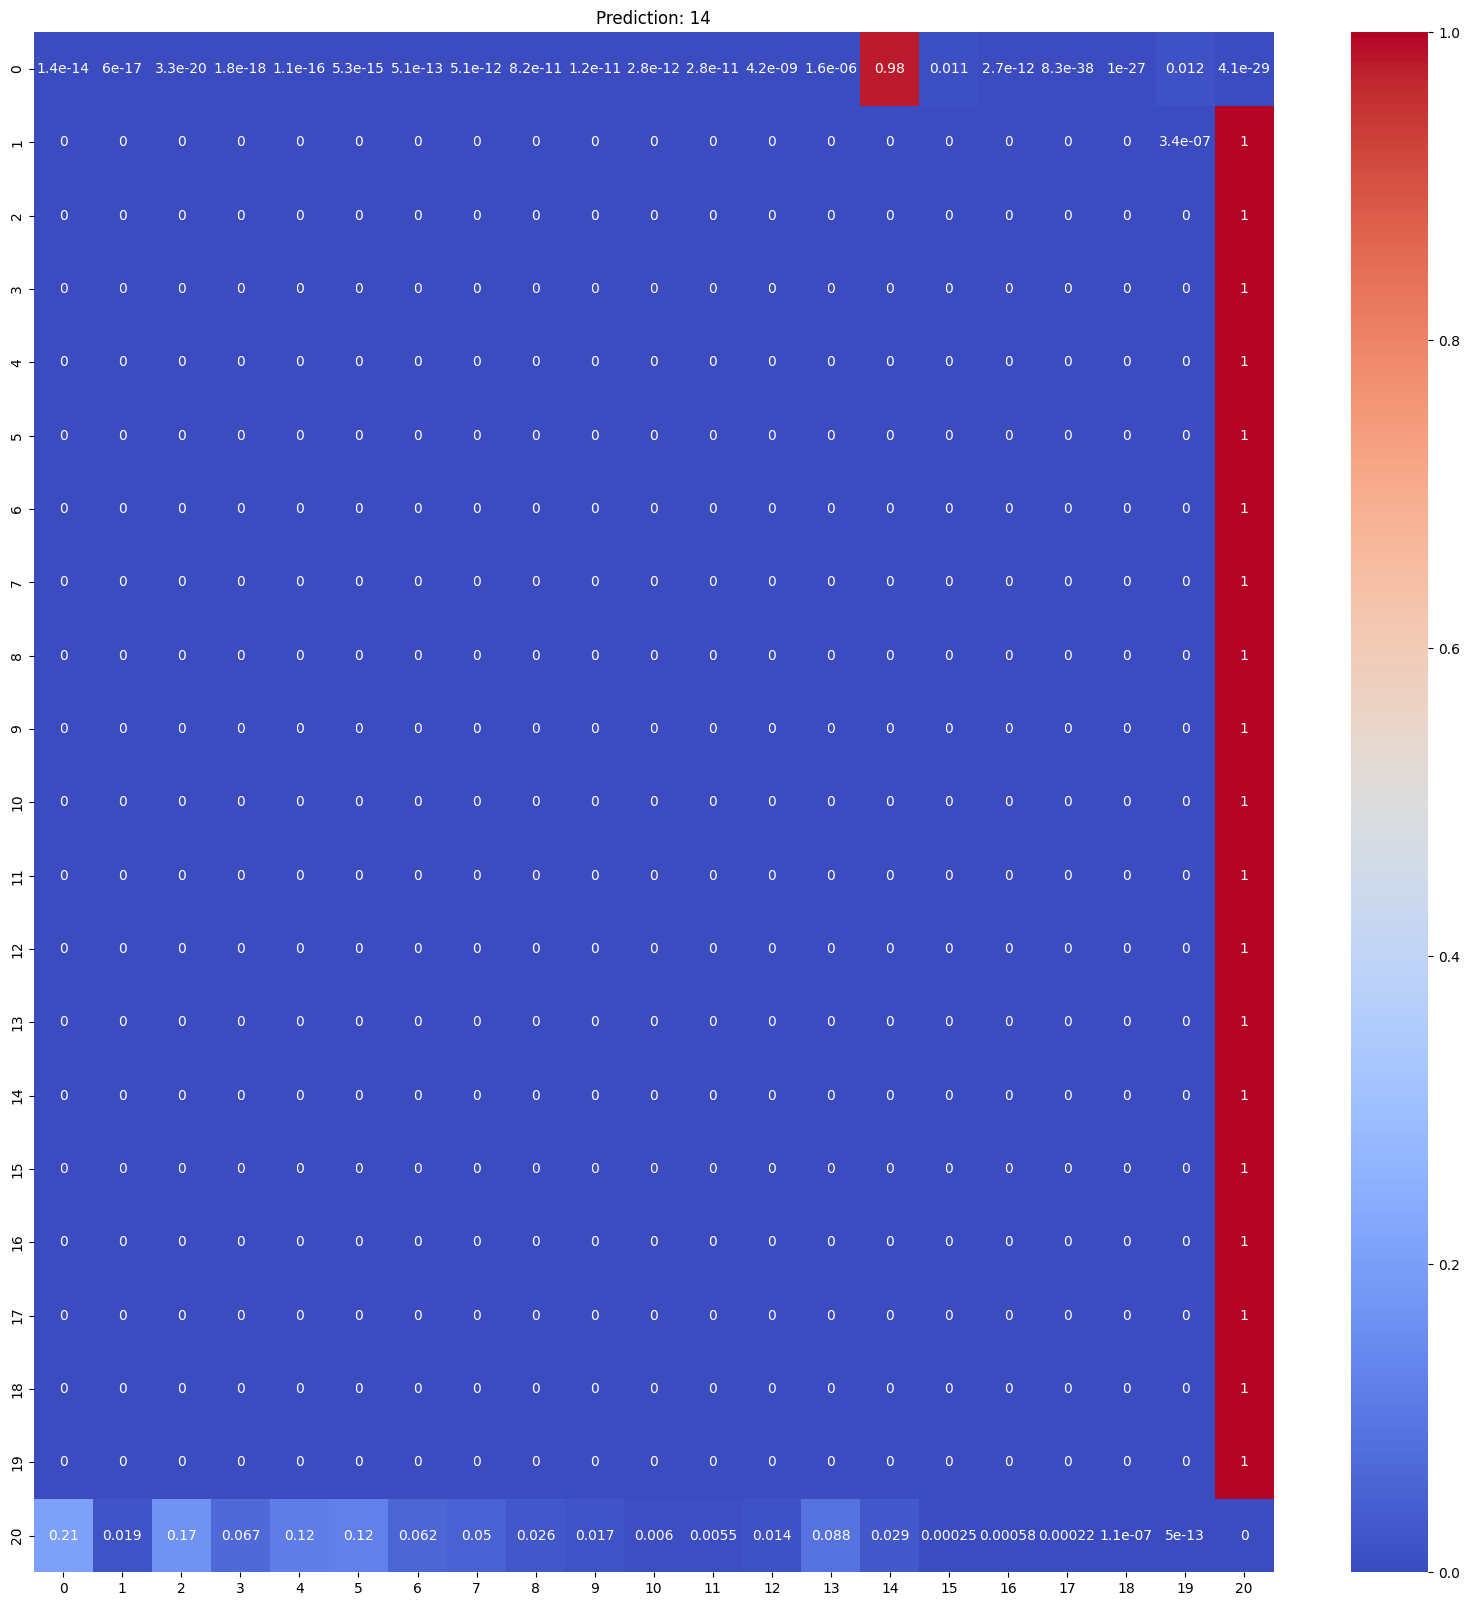

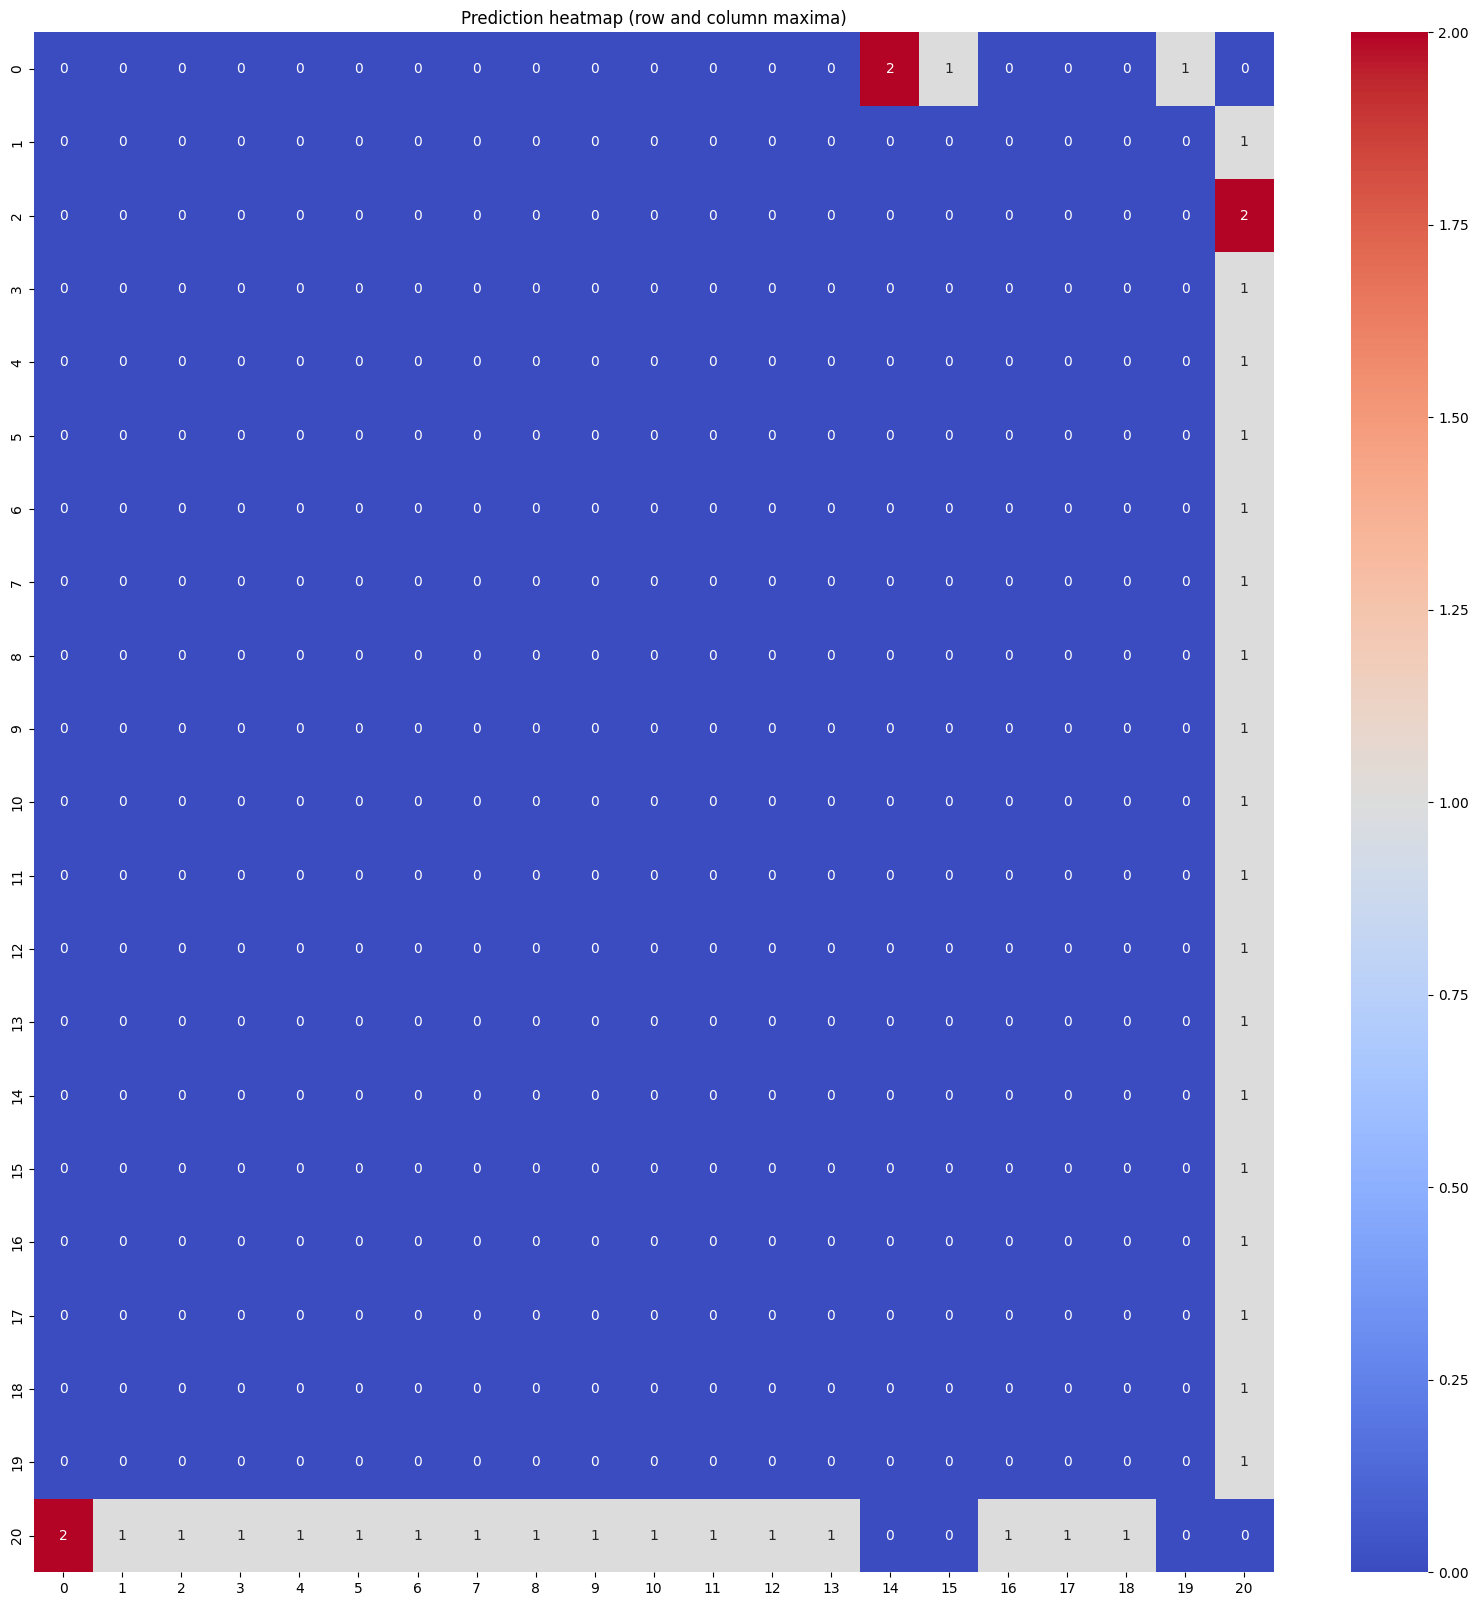

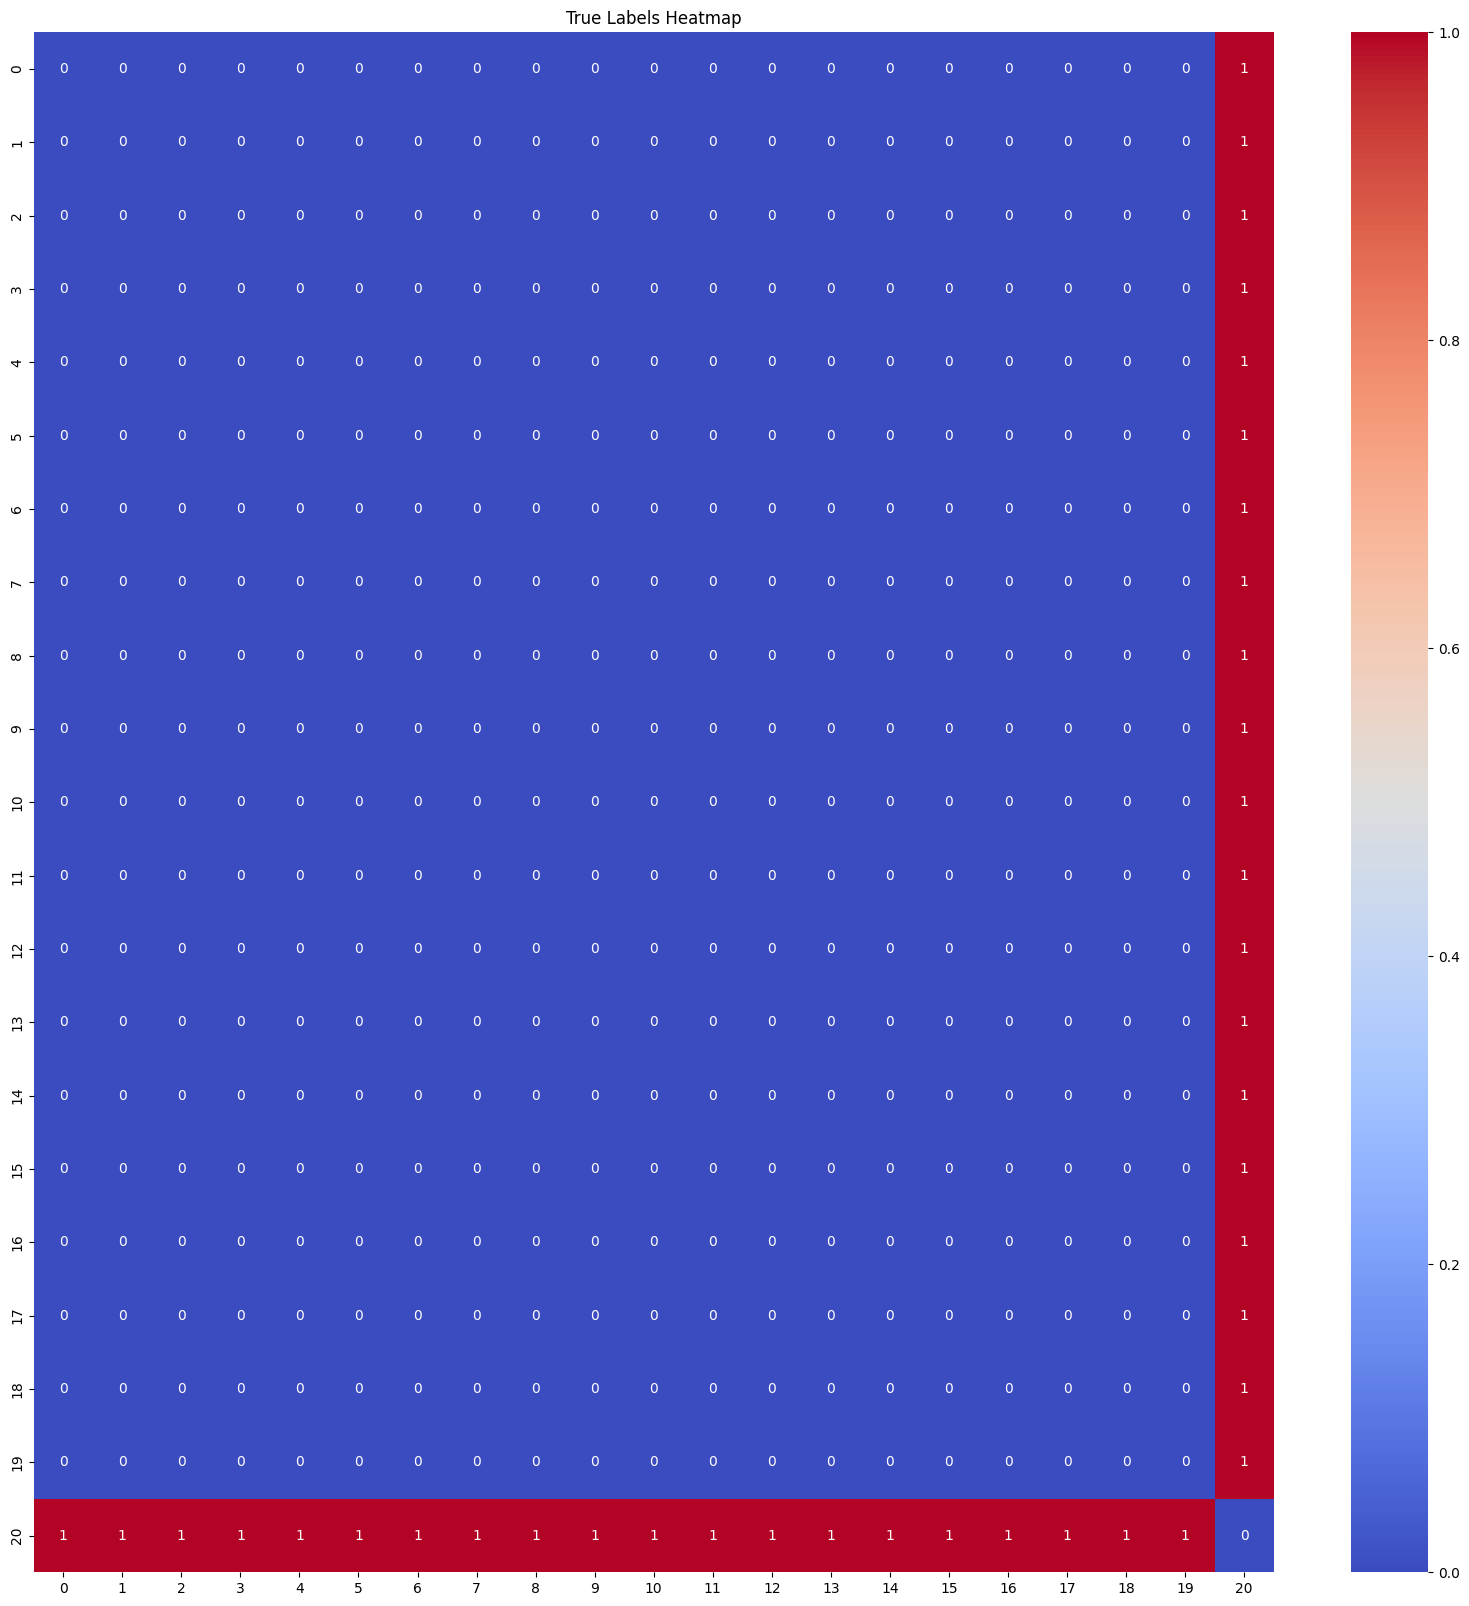


Heatmap visualization for first prediction:


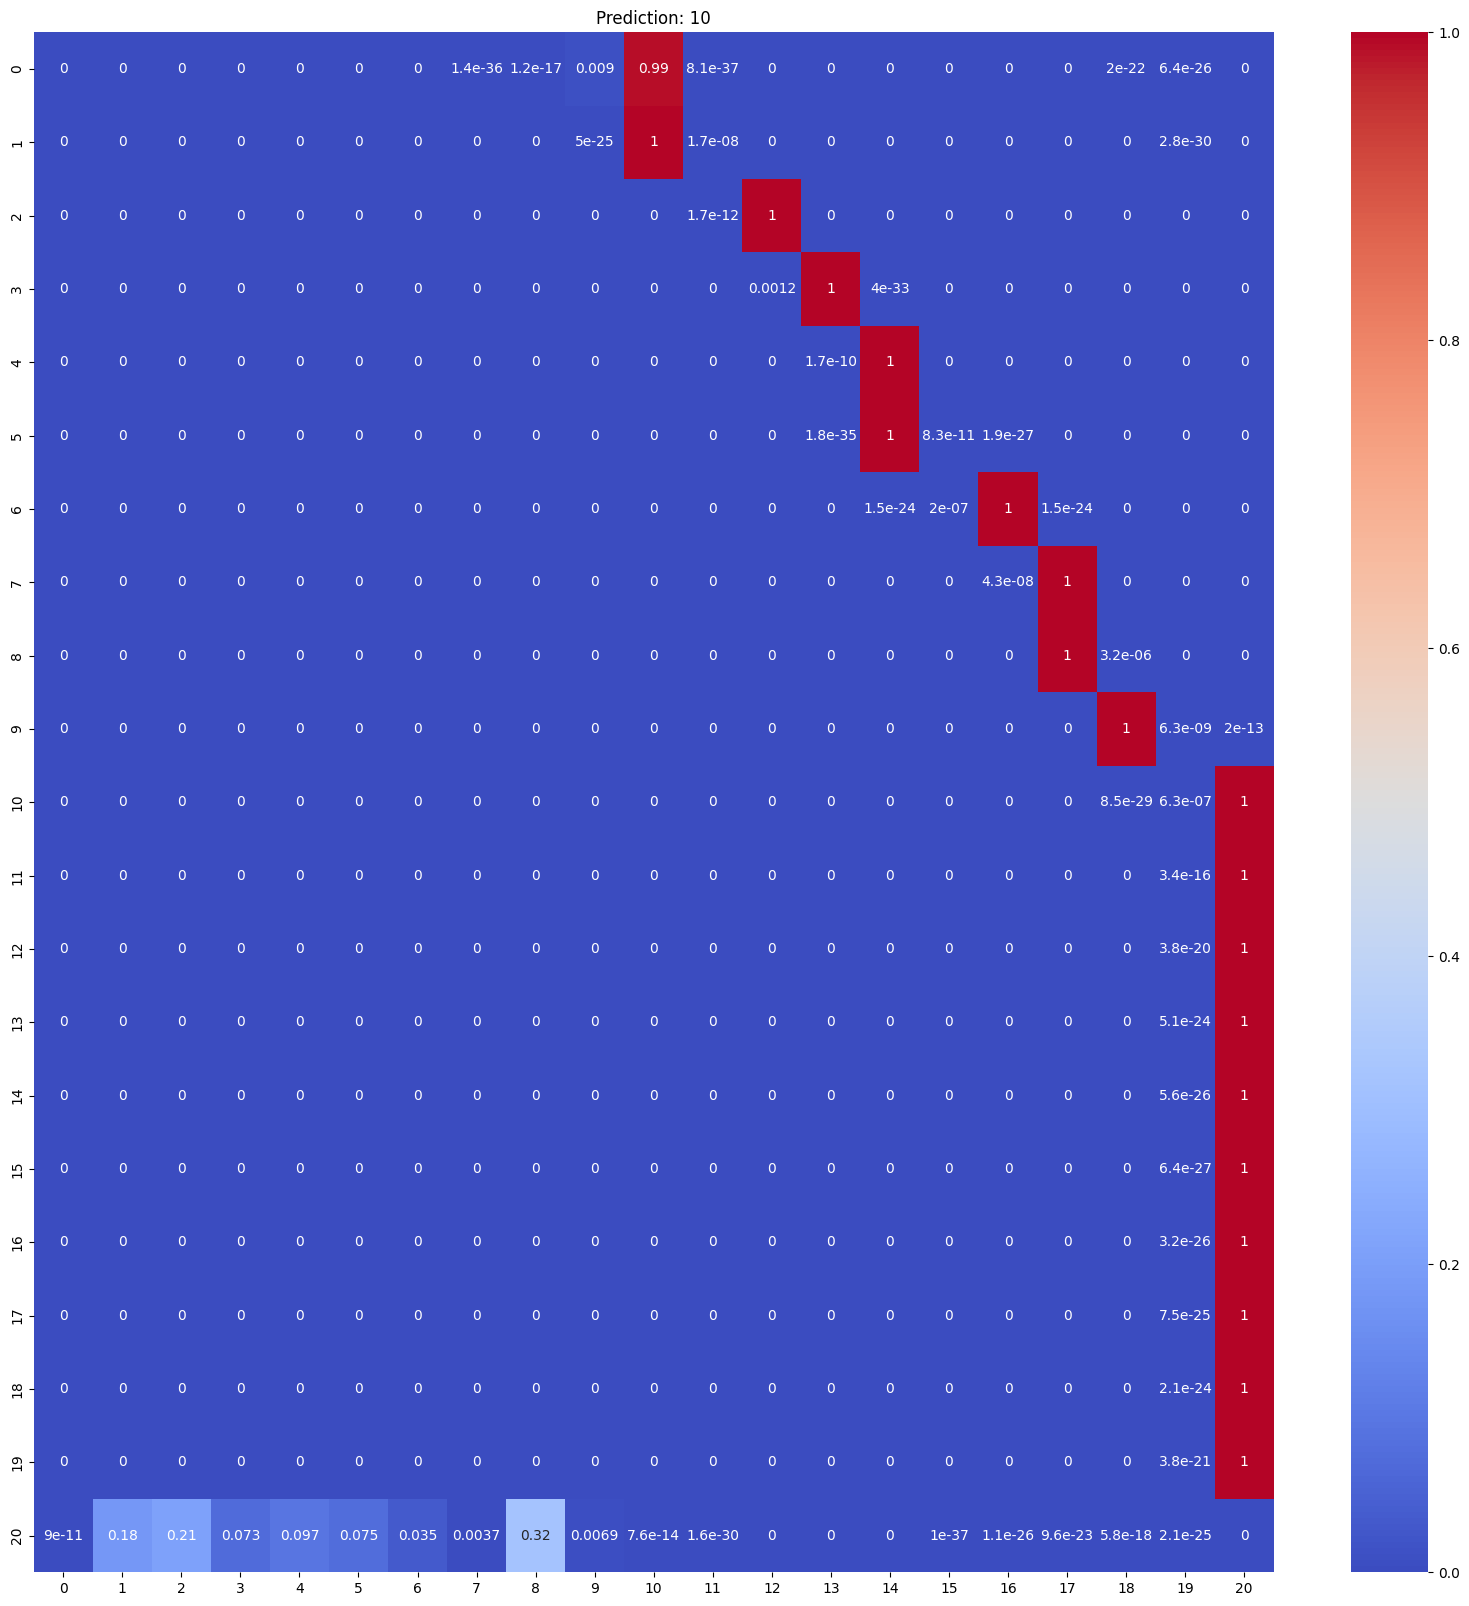

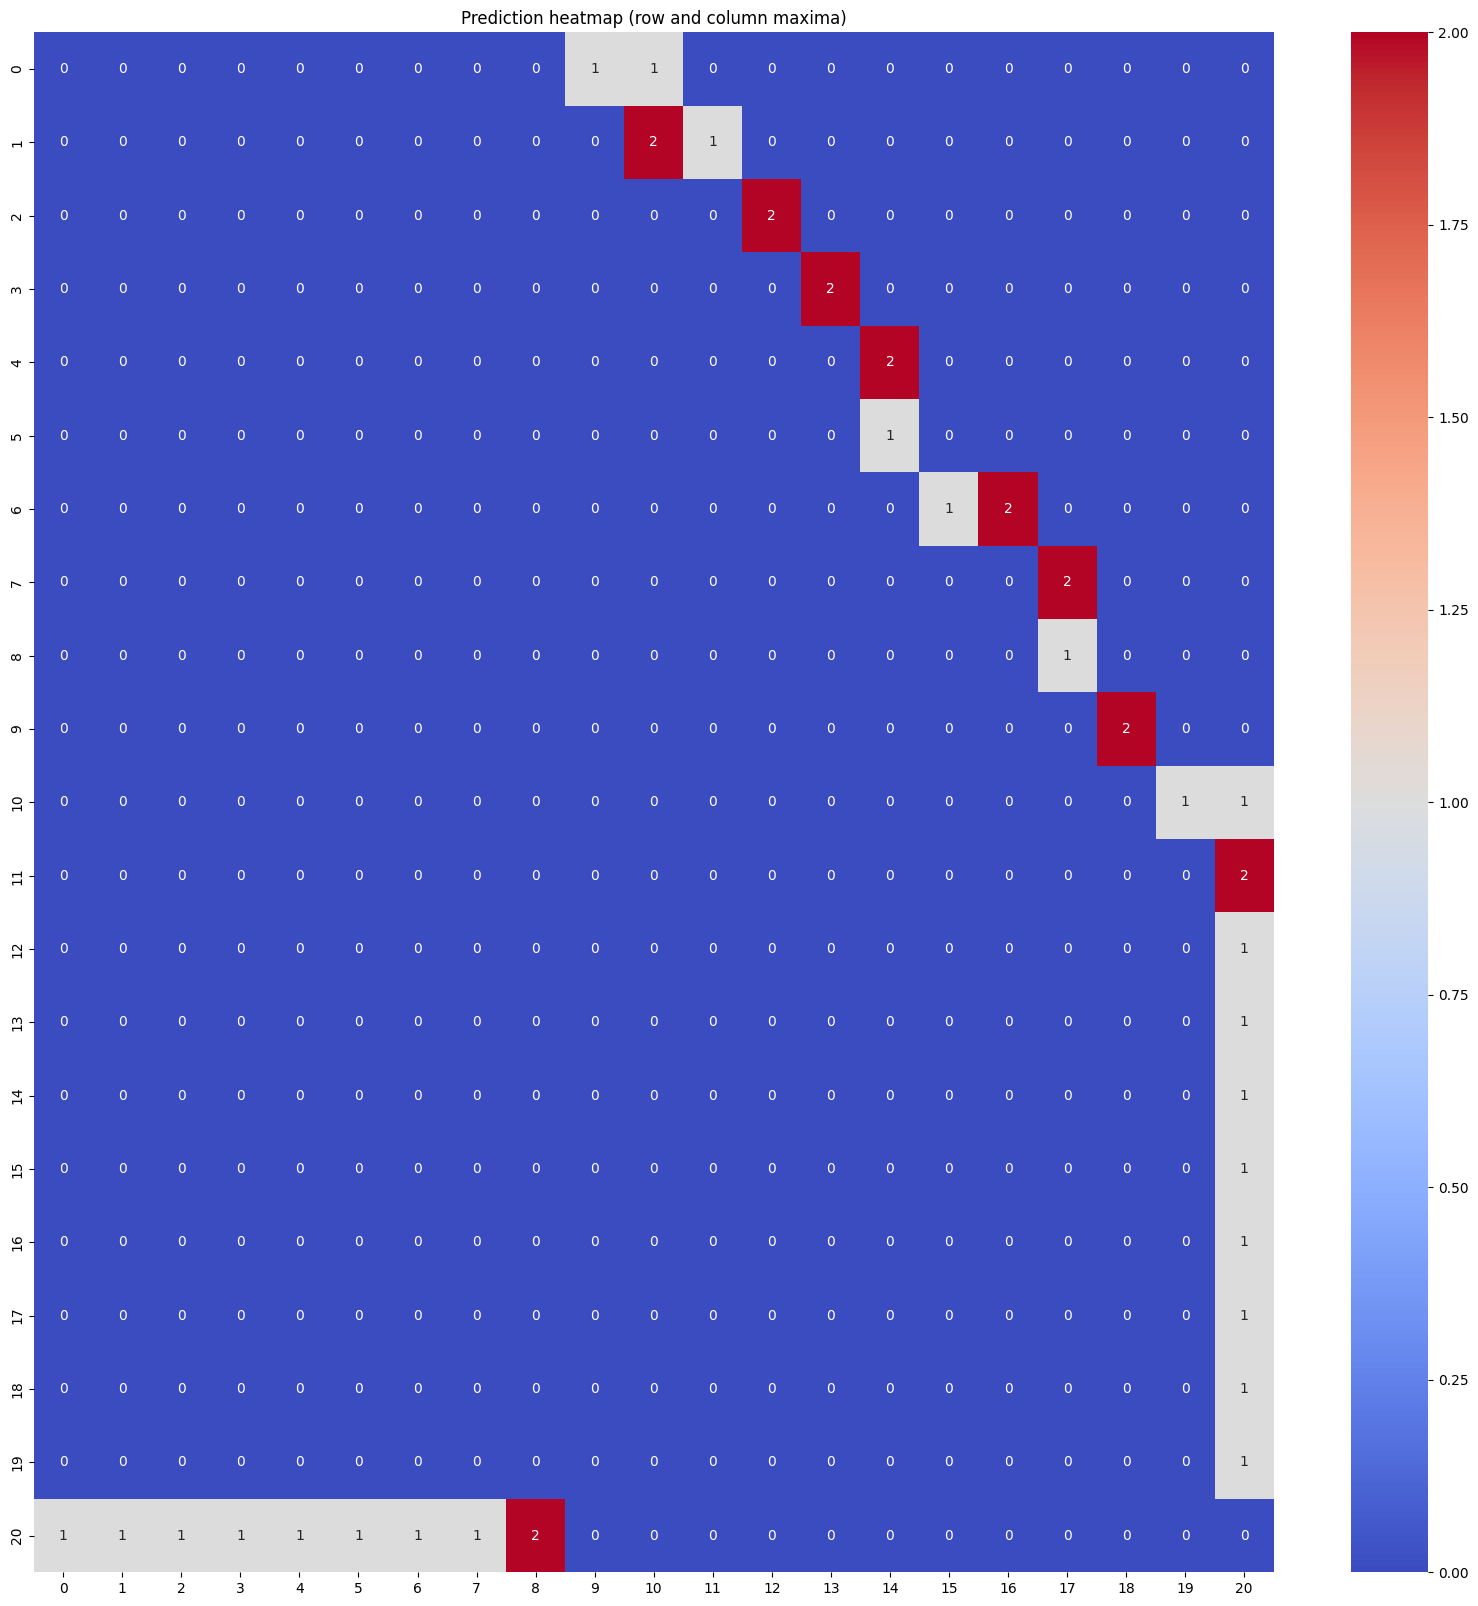

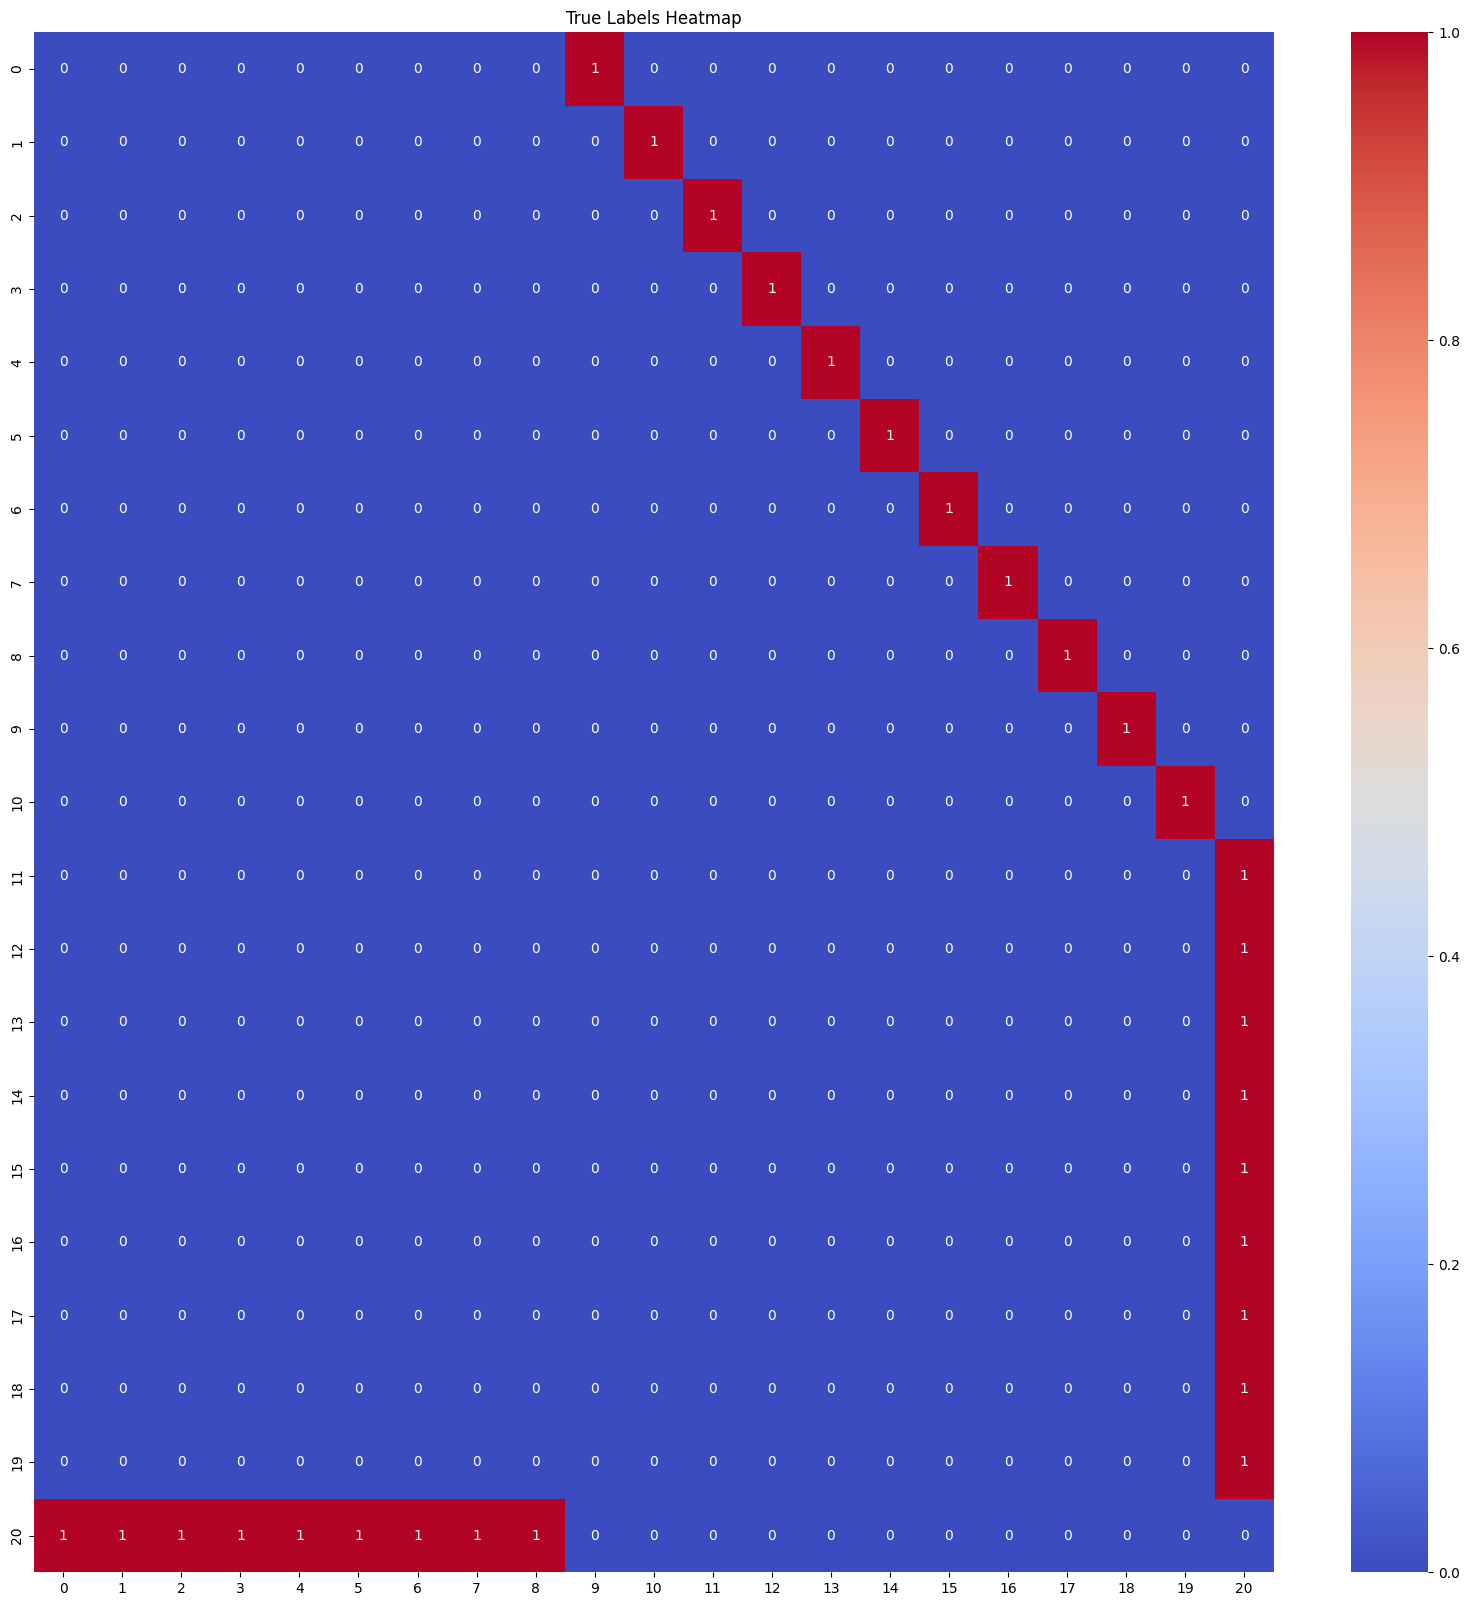


Heatmap visualization for first prediction:


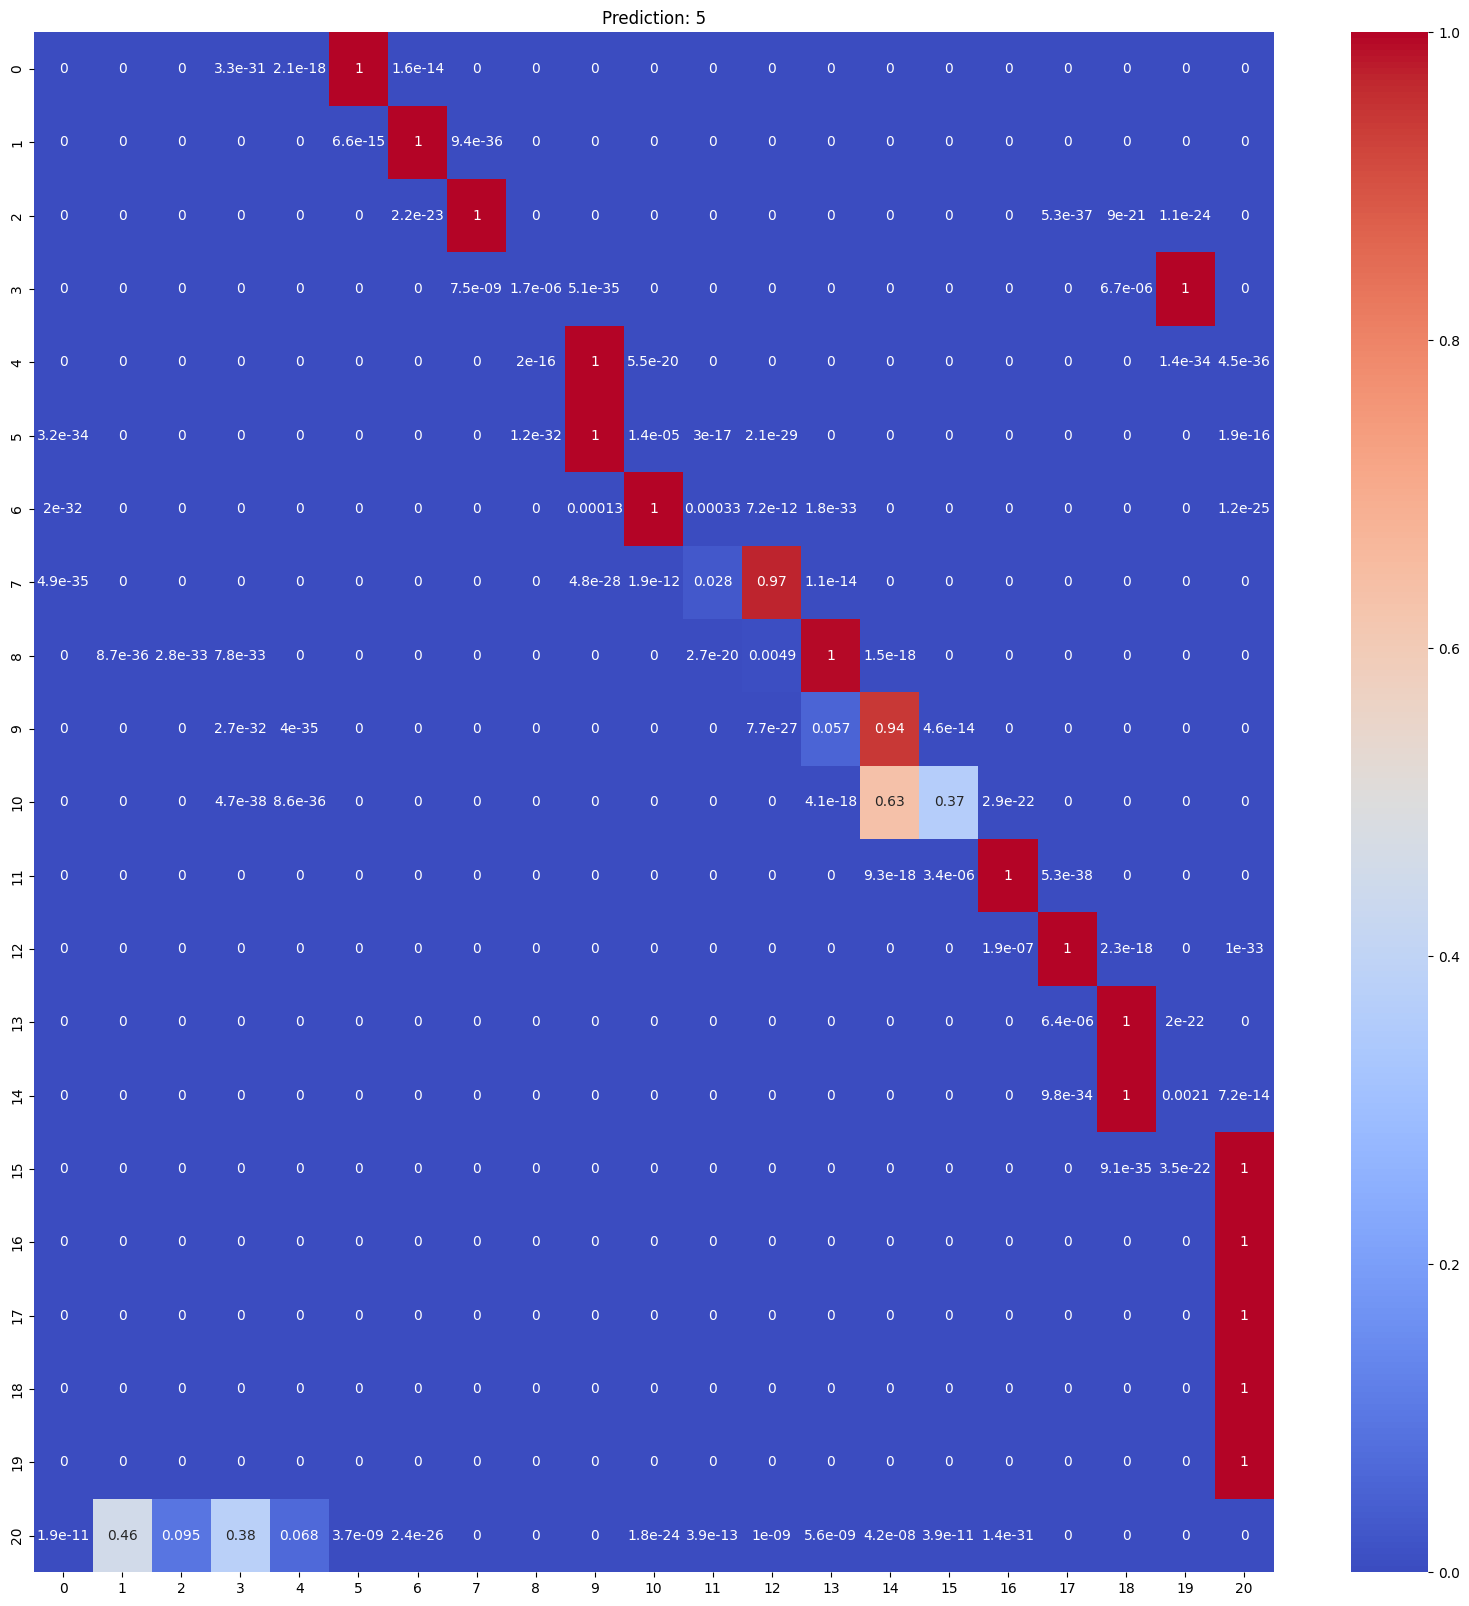

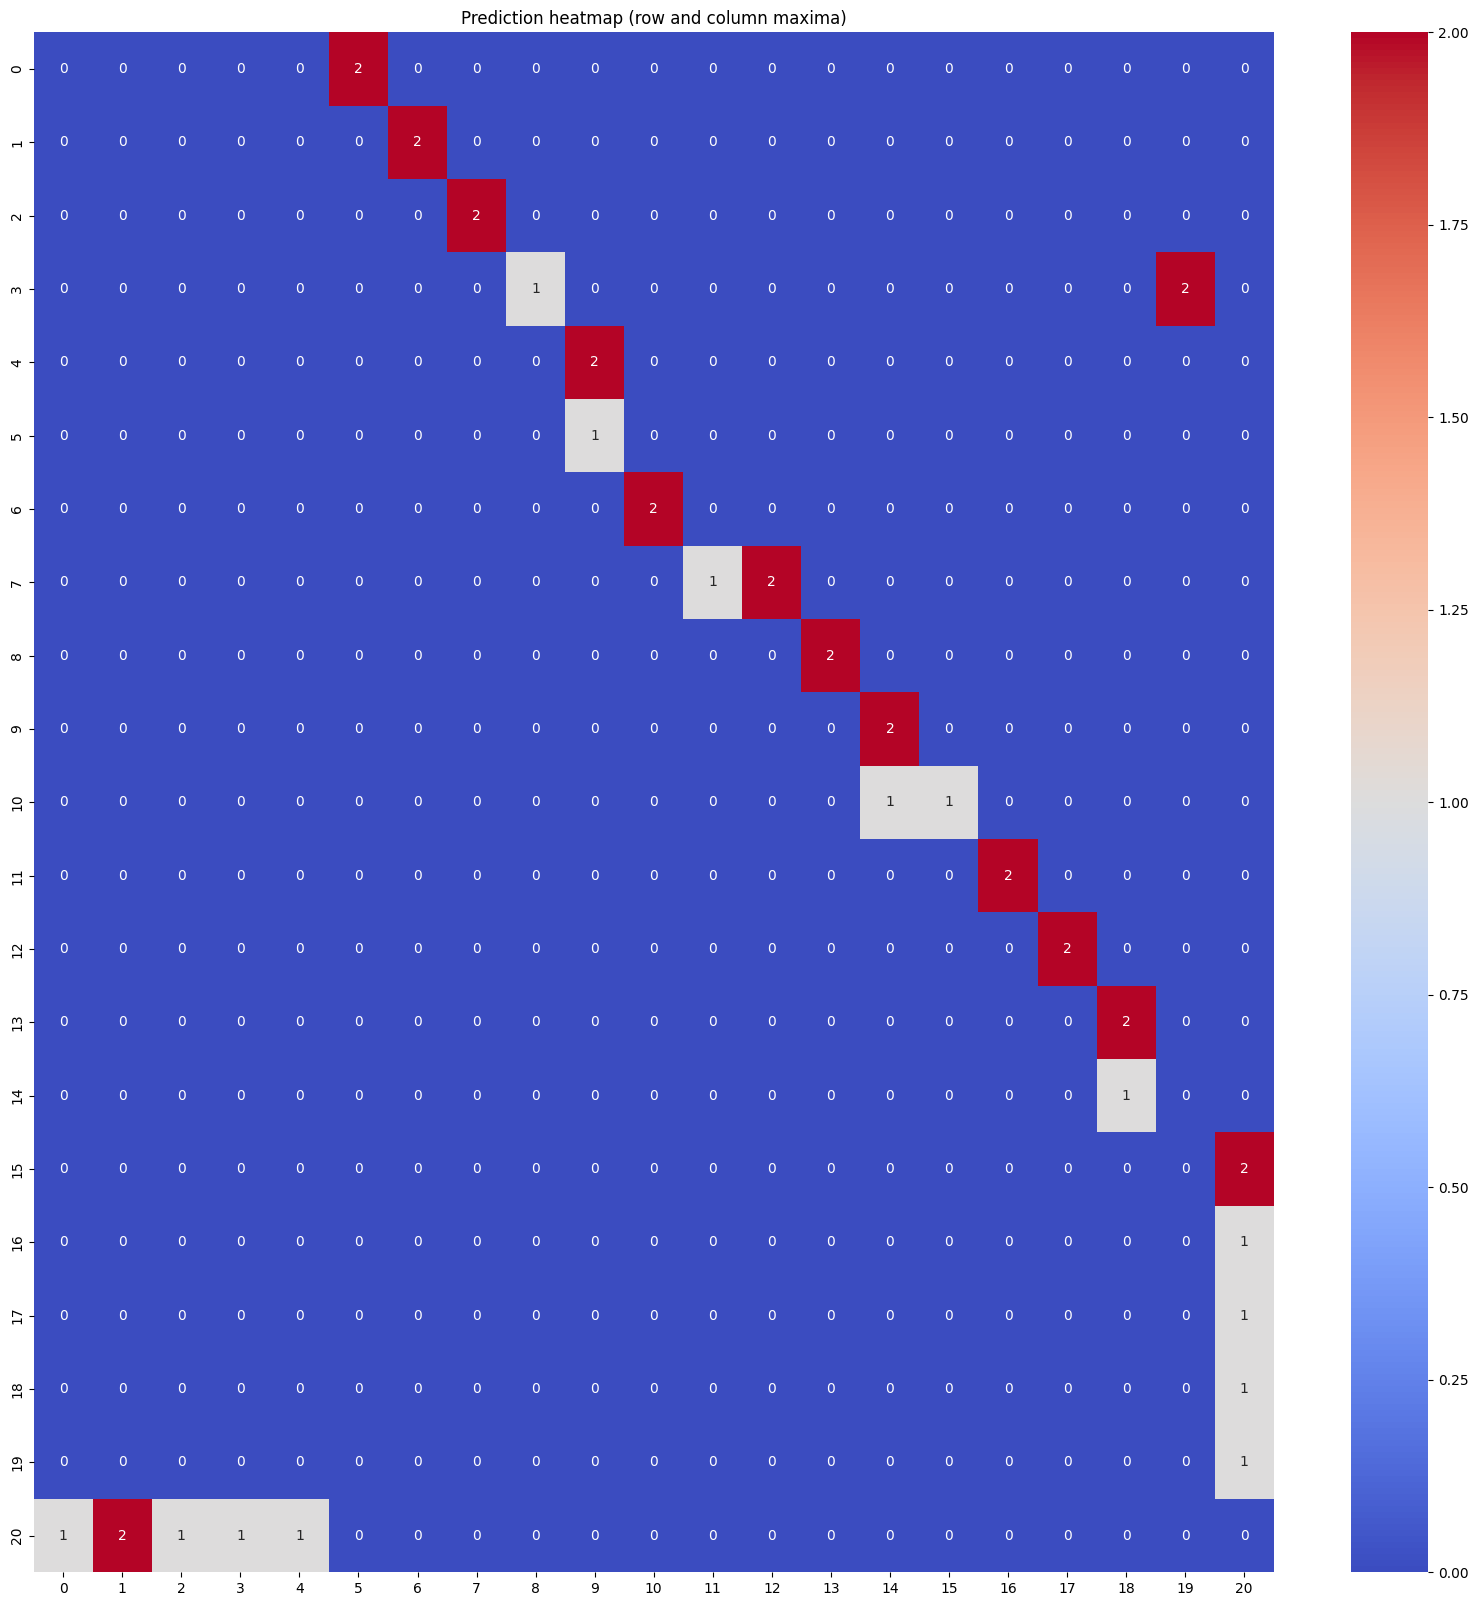

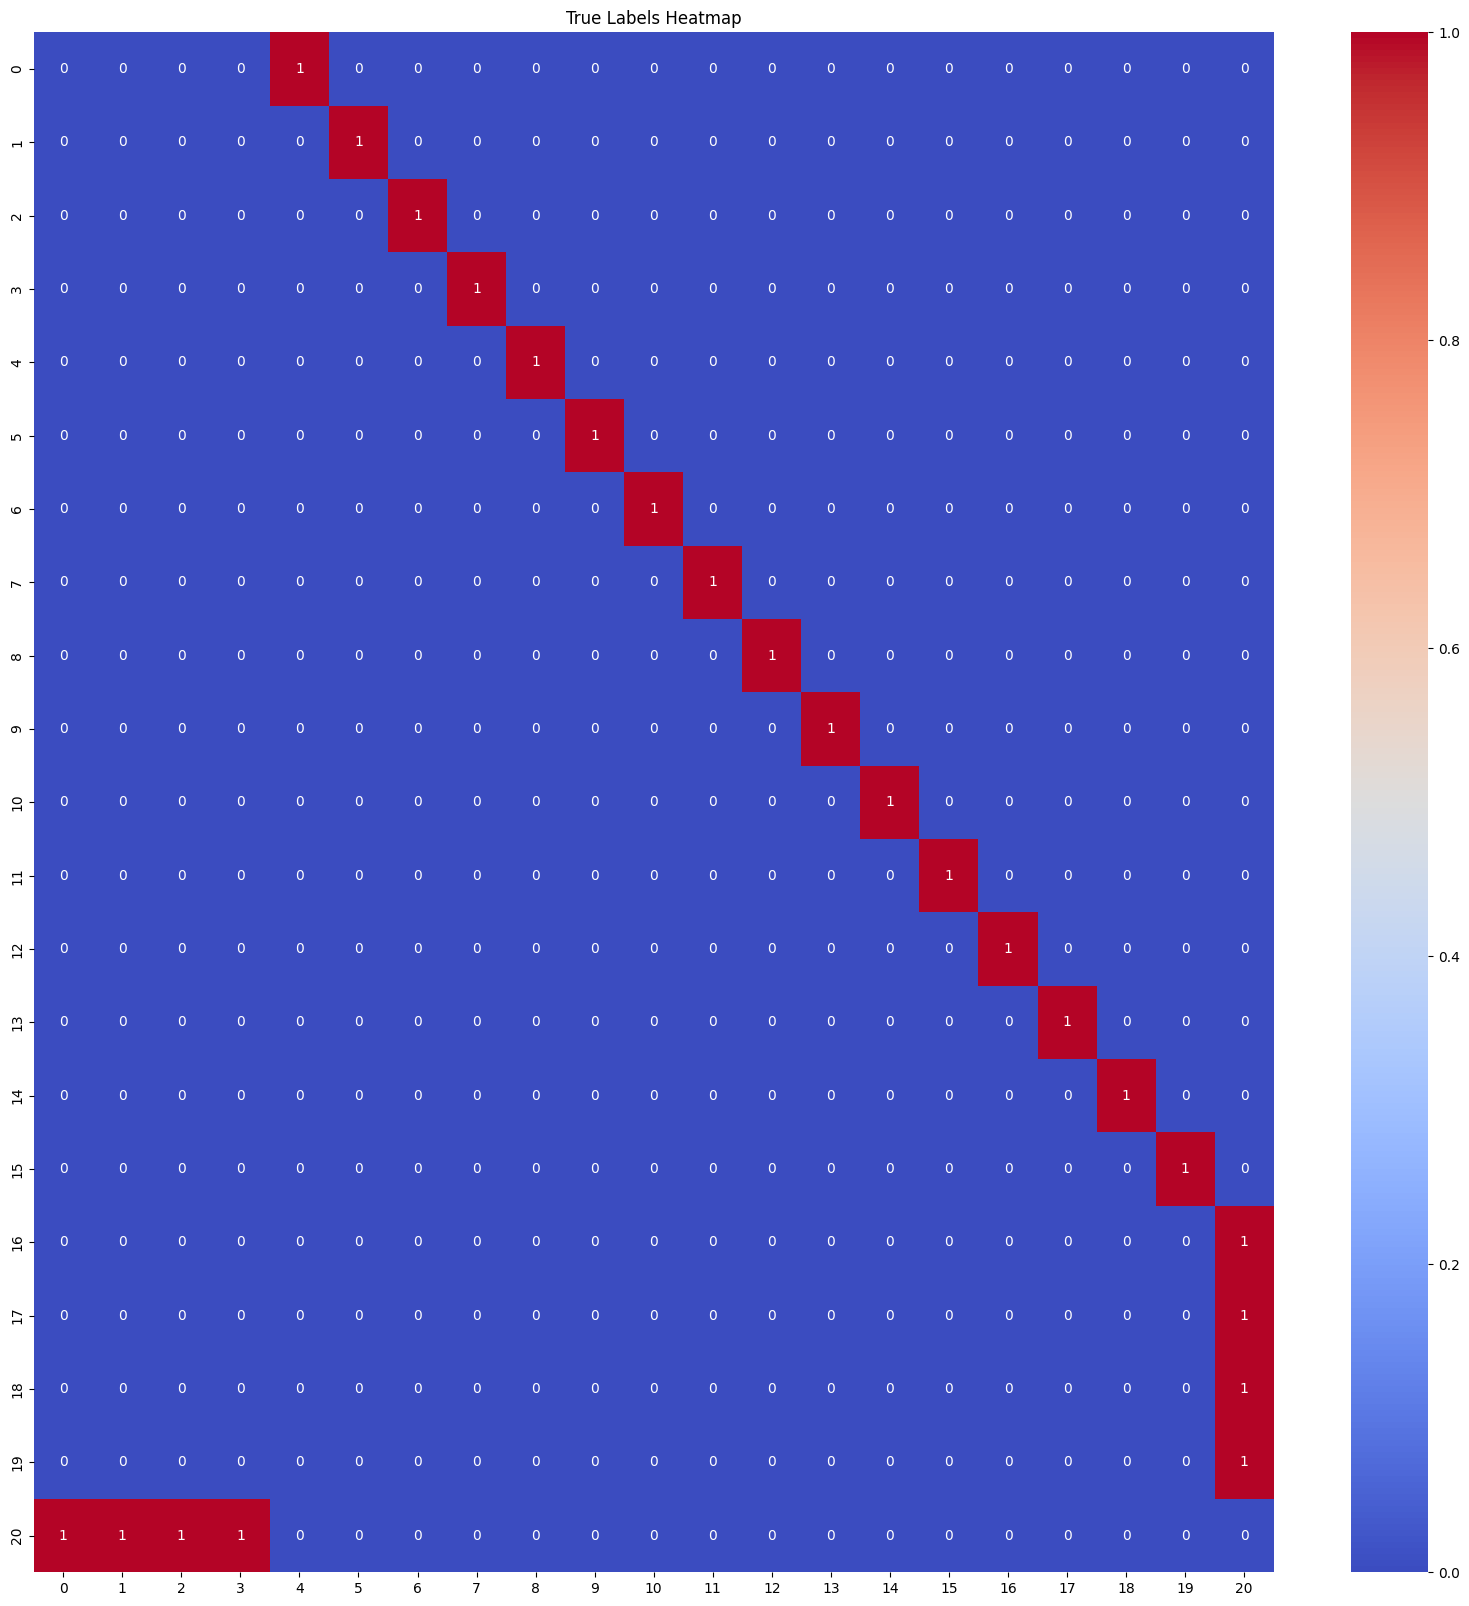

In [11]:
num_heads = 4  # 8,4,1,2
embed_dim = 48  # 768  48
num_layers = 2  # 4,2,1
lr = 1e-3
len_video = 20
batch_size = 1024

# TD model setting
weight_name = "weights_v2_.h5"
print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}",f"lr : {lr}",
      f"batch_size: {batch_size}",f"Weight name: {weight_name}", sep="\n")

# training
feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"
print(f"feature_loc: {feature_loc}")

model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

# testing
feature_loc_test = "/home/jireh/MT/video_sync_v1/trash/featureData_1.npy"
print(f"feature_loc_test: {feature_loc_test}")

model.pred(
    feature_loc_test,
    weight_name=weight_name,
    video_pair = "12_02, 12_03",    ### !!!
    output_path=f"/home/jireh/MT/video_sync_v1/trash/output_test"
)

In [8]:
num_heads = 4  # 8,4,1,2
embed_dim = 48  # 768  48
num_layers = 2  # 4,2,1
lr = 1e-3
len_video = 20
batch_size = 1024

# TD model setting
weight_name = "weights_v2_.h5"
print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}",f"lr : {lr}",
      f"batch_size: {batch_size}",f"Weight name: {weight_name}", sep="\n")

# training
feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"
print(f"feature_loc: {feature_loc}")

model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

# testing
feature_loc_test = "/home/jireh/MT/video_sync_v1/trash/featureData_1.npy"
print(f"feature_loc_test: {feature_loc_test}")

model.pred(
    feature_loc_test,
    weight_name=weight_name,
    video_pair = "12_02, 12_03",    ### !!!
    output_path=f"/home/jireh/MT/video_sync_v1/trash/output_test"
)

Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 2
lr : 0.001
batch_size: 1024
Weight name: weights_v2_.h5
feature_loc: /home/jireh/MT/video_sync_v1/trash/featureData_21.npy


2024-11-14 18:12:36.316752: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-14 18:12:36.401132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-14 18:12:36.401491: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-14 18:12:36.404783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

feature_loc_test: /home/jireh/MT/video_sync_v1/trash/featureData_1.npy
y_true label:[20, 9, 4, 13, -12, 1, -11, -2, -1, 10]
Model initialized. Starting predictions...
weights loaded: weights_v2_.h5
Average rows_cols_crossentropyLoss: 8.092768669128418

Final predictions after training:
Predicted: [14, 10, 5, 13, -17, -1, -12, -2, -1, 10, 15, -6, -17, 5, -15, -18, -6, -10, -6, -9, -18, -6, -15, -1, 12, -6, 19, 18, -15, -5]
True: [<tf.Tensor: shape=(21, 21), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.],
       [0., 

ValueError: Classification metrics can't handle a mix of unknown and multiclass targets

In [ ]:
num_heads = 4  # 8,4,1,2
embed_dim = 48  # 768  48
num_layers = 2  # 4,2,1
lr = 1e-3
len_video = 20
batch_size = 1024

# TD model setting
weight_name = "weights_v2_.h5"
print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}",f"lr : {lr}",
      f"batch_size: {batch_size}",f"Weight name: {weight_name}", sep="\n")

# training
feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"
print(f"feature_loc: {feature_loc}")

model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers, sequence_length=len_video)

# testing
feature_loc_test = "/home/jireh/MT/video_sync_v1/trash/featureData_1.npy"
print(f"feature_loc_test: {feature_loc_test}")

model.pred(
    feature_loc_test,
    weight_name=weight_name,
    video_pair = "12_02, 12_03",    ### !!!
    output_path=f"/home/jireh/MT/video_sync_v1/trash/output_test"
)

In [9]:
a = "1,2,3,4,5"
a[:-1]

'1,2,3,4,'

In [12]:
a= f"/beegfs/home/users/j/jireh_7/dataset/Panoptic/('12_02', '12_03')/test/featureReference_len20_val.npy"

a[:-4]


"/beegfs/home/users/j/jireh_7/dataset/Panoptic/('12_02', '12_03')/test/featureReference_len20_val"